# Analyze contact interactions of Hv1-2GBI system.

By: Victoria Lim  
Last updated: 2018-03-05

This notebook processes the pickled pandas dataframe of contact interactions. The contact interactions are based off graph representation of protein-ligand system and are calculated using Tcl scripts with VMD (see references below).  

Pickle file details:
- Generated from: `/beegfs/DATA/mobley/limvt/hv1/04_fep/postFEPvanilla/analysis/3_nonCovInts/nodeContacts.py`
- Pickle dump line: `pickle.dump((nodes, edges), open( pickleOut, "wb" ) )`

**Notebook inputs**:  
Nodes and edges are pandas dataframes as generated in the above script.
- Node example:

|index|resname | resid | location | type | code | nAtoms |
|-----|--------|-------|----------|------|------|--------|					
|1|	PHE|	88|	bb|	POS|	NT|	1|
|2|	PHE|	88|	sc|	NOP|	AB|	2|
|3|	PHE|	88|	sc|	NOP|	GDEZ|	6|
|4|	ARG|	89|	sc|	NOP|	AB|	2|
|5|	ARG|	89|	sc|	NOP|	GD|	2|

- Node details:
  - TODO



- Edge example:

||node_i | node_j | weight | attribute | count | average |
------------------------------------------------------- |
|34647 |	165 | 174 |	132 |	HPHOB | 97.0 | 1.360825 |
|34648 |	165	| 175 | 322 |	HPHOB | 130.0 | 2.476923 |

- Edge details:
  - First column is the pandas dataframe index. This value is not significant.
  - `node_i`: TODO -- include notes from README and reference for Benson&Daggett
  - `node_j`: The node interacting with `node_i`. The value of `node_j` should always be greater than or equal to that of `node_i`.
  - `weight`: Each node has a variable number of atoms. The weight of an interaction is the number of interactions for the atoms in `node_i` to the atoms in `node_j`. The weight listed is the sum over all frames of the weights found for this node pair.
  - `attribute`
  - `count`: Number of trajectory frames this edge interaction was found.
  - `average`: This is taken as the quotient of `weight`/`count`.

**Troubleshooting**:
* If you subtract two edge dataframes and lose most interactions, it might be that the node indices don't match up.   
  * For example, let's say dataframe_1 has the node_35 to node_99 interaction as an HBOND,  
but dataframe_2 shows the node_35 to node_99 interaction as COUL (Coulombic) interaction.  
There was a mutation associated with dataframe_2, which knocked out 5 nodes, starting at node_80.  
Then the real match of dataframe_1's node_35 to node_99 for dataframe_2 is with node_35 to node_94.  
  * This _shouldn't_ be an issue since the `diffEdges` function should take out any edge involving  
any mutation-related notes, and then scale the rest of the edges by that offset.  
(By the way, this function does have a pretty limited use-case currently, so check the documentation.)
  * To determine if this is the case, look for the line:  
`diff_edges_x = noMut_edges_x.merge(noMut_edges_y,on=['node_i','node_j','attribute'],how='inner')`  
(or the analogus merge line), and take out the requirement to match on attribute as well as on nodes:  
`diff_edges_x = noMut_edges_x.merge(noMut_edges_y,on=['node_i','node_j',],how='inner')`.  
Print and scrutinize the resulting edges dataframe, such as using `head()`, `tail()` or `iloc[range1:range2]`.

* If you `.apply` some function to a pandas dataframe column and get some error:  
Try iterating over the column and applying that function one-by-one to look for the bug.  
`for i, (index, row) in enumerate(diff_edges_1.iterrows()):`

* If you see `SettingWithCopyWarning`, it's probably because you're altering some dataframe that's likely a copy of the original. That might be fine if you have just one change to make (e.g., I was able to increment all of `node_i`). However, if you have to work with it further, then consider wrangling with `.loc` (or similar) functions for modifying the bona fide dataframe (e.g., when I then tried to increment `node_j`, the original changes to `node_i` were gone).

**References**:
* Nodes and edges of protein adapted from [Benson and Daggett](https://dx.doi.org/10.1142%2FS0219720012500084).
* Tcl scripts written by Eric Wong and Alfredo Freites. 

**Questions to self**:
* For a heat map of edge differences, such as before and after mutation, what cutoff is significant? Do you notice in the trajectory, for example, when the data says the interaction between F150 and 2GBI:benzo decreases by '-5'?

___________________________________________________________________

**TODO**: 
* subtract edges for 2GBI taut2 and taut1 by connecting benzo--benzo, guan--guan, CNN--(NN+CN)
* update function documentation to numpy format
   * https://github.com/numpy/numpydoc/blob/master/doc/example.py
   * https://samnicholls.net/2016/06/15/how-to-sphinx-readthedocs/
* make the heatplot a 3D plot colored by inttype (e.g., COUL)
* is it valid to subtract edge data when the averages may have come from different-length trajectories?

**Glossary of some variables defined in this notebook**

Nodes
* nodes_1             : nodes of mutant, read from file
* wt_nodes_1          : nodes of WT, read from file
* diff_nodes_1        : nodes of WT, mutation residue removed
* dry_diff_nodes_1    : nodes of WT, mutation residue removed, sumWat node added

Edges
* edges_1             : normal edges of mutant, read from file
* wt_edges_1          : normal edges of WT, read from file
* diff_edges_1        : normal edges of (mutant-WT) interactions, mutation residue removed
* dry_diff_edges_1    : normal edges of (mutant-WT) interactions, mutation residue removed, all water interactions summed
* pivot_diff_edges_1  : pivoted edges of DRY (mutant-WT) interactions

2GBI
* mut_gbi1_edges      : pivoted edges of 2GBI interactions in mutant
* wild_gbi1_edges     : pivoted edges of 2GBI interactions in WT
* sim_mut_gbi1_edges  : pivoted edges of 2GBI interactions common to mutant and WT

Water
* waterEdges_1        : pivoted edges of sumWat interactions
* sim_waterEdges_1    : pivoted edges of sumWat interactions common to taut1 and taut2

**Table of Contents**  

1. Load in data  
    1. Demonstrate some functions defined in this notebook

2. Analyze interactions before and after mutation
    1. Focus on whole protein-ligand system
        1. Tautomer 1
        2. Tautomer 2
        3. No ligand
    1. Focus on ligand-specific interactions
        1. Tautomer 1
        2. Tautomer 2
        3. No ligand
    1. Focus on relative hydration by residue
        1. Tautomer 1
        2. Tautomer 2
        3. Both tautomers in common
        4. Verify hydration in edges
    1. Focus on other defined interactions
        1. D112
        2. D185
        3. R211
        
3. Analyze interactions differentiating tautomers
    1. Focus on whole protein-ligand system
        1. After mutation
        2. Before mutation
    1. Focus on ligand-specific interactions
        1. After mutation
        2. Before mutation

4. Analyze differences wrt thermodynamic cycle

5. Analyze interactions directly from computed edges
    1. Focus on whole protein-ligand system
        1. After mutation
            1. Tautomer 1
            1. Tautomer 2
        2. Before mutation

6. Troubleshooting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

np.__file__

'/mnt/c/Users/limtv/Documents/vtl_programs/miniconda3/envs/oepython3/lib/python3.6/site-packages/numpy/__init__.py'

In [2]:
# define global variables for this notebook
mutcode = 'R211S'

In [3]:
def getEdgePair(node1, node2, edges):
    """
    TODO
    
    Notes
    -----
    Can't find the interaction you're looking for? Might need to
    add/subtract an offset if you used the diffEdges function. 
    The offset value (with sign and magnitude) should have been
    printed out: "Shifting node indices by..."
    
    """
    return edges[(edges.node_i == node1) & (edges.node_j == node2)]

def getContactPair(res1, res2, nodes, edges):
    """
    TODO
    
    Parameters
    ----------
    res1
    res2 | int | other protein residue number. this int should be less than res1
    nodes
    edges
    
    Returns
    -------
    TODO
    
    """
    df1 = getResidInfo(res1,nodes,resExcludes=['WAT'])
    df2 = getResidInfo(res2,nodes,resExcludes=['WAT'])
    indexList1 = df1.index.tolist()
    indexList2 = df2.index.tolist()
    print(df1, '\n\n', df2)
    
    return edges[(edges.node_i.isin(indexList1)) & (edges.node_j.isin(indexList2))]    

def findInEdges(nodeNum, edges, att=None):
    """
    Find the specified node index in either node_i or node_j columns of input edges df.
    
    Parameters
    Returns
    """
    edges = edges.copy()
    if att is not None:
        return edges[(edges.attribute == att) & ((edges.node_i == nodeNum) | (edges.node_j == nodeNum))]
    else:
        return edges[(edges.node_i == nodeNum) | (edges.node_j == nodeNum)]
    

def getResidInfo(resid, nodes, resExcludes=[]):
    """
    Get the node information for specified protein residue index.
    
    Parameters
    ----------
    nodes: pandas dataframe of nodes
    resid: integer value of the protein residue index
    resExcludes: list of strings, for each residues to ignore.
                 e.g., ['WAT']
    Returns
    -------
    nodes_id: pandas dataframe with only residue of interest
    
    """
    nodes_id = nodes.loc[nodes['resid'] == resid]
    nodes_id = nodes_id[~nodes_id.resname.isin(resExcludes)]

    return nodes_id



def idxToResid(idx, nodes, idOnly=False):
    """
    This function takes in some node index and generates 
    a string code of one-letter residue name and integer of residue number.
    
    Parameters
    ----------
    idx    | int       | integer index of the pandas dataframe
    nodes  | pandas df | pandas dataframe of which to search
    idOnly | Bool      | specify True to return numpy.int64 of residue number
                         specify False to return code with resname abbrev
                         ex., True returns 150; False returns 'F150:sc'
    Returns
    -------
    code - string or numpy.int64 value of residue. (see idOnly parameter)
    
    """
    aa_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'HSD': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M',
     'GBI1':'GBI1', 'GBI2':'GBI2', 'WAT':'WAT'}
    
    #old way not conducive to taking diff of dataframes
    #entry = nodes.iloc[idx-1]
    entry = nodes.loc[nodes.index == idx] # iloc gives series, loc gives dataframe
    entry = entry.T.squeeze() # convert from dataframe to series
    resname = entry['resname']
    if resname in ['GBI1','GBI2']:
        code = aa_dict[resname]+':'+entry['code']
    elif resname == 'WAT':
        code = aa_dict[resname]+str(entry['resid'])
    else: # if not GBI or WAT, must be Hv1
        if idOnly: code = entry['resid']
        else: code = aa_dict[resname]+str(entry['resid'])+':'+entry['location']       

    return code

In [4]:
def prioritizeOrPivot(edges, prioritize=True, rawNum=None):
    """
    Pull out N strongest interactions, or pivot the table.
    Not meant for user; implemented in protLigInts and selectionInts functions.
    This function handles cases of whether dataframe has edges or difference of edges.
    """
    edges = edges.copy()
    if prioritize:
        if rawNum is None:
            print("ERROR: rawNum variable was not passed into prioritizeOrPivot function")
            return None
        try: # Pull out the N strongest interactions (should be no negative values)
            edges = edges.sort_values('average',ascending=False).head(rawNum)
        except KeyError: # if no 'average' column then this is one df minus another so there are negatives
            # sort by magnitude to get + and - changes
            tempinds = edges.avg_subt.abs().sort_values(ascending=False).head(rawNum).index
            edges = edges.loc[tempinds]
        return edges
    
    else: # pivot table for plotting
        try:
            edges = edges.pivot(index='node_i',columns='node_j', values='average')
        except KeyError:
            edges = edges.pivot(index='node_i',columns='node_j', values='avg_subt')
        edges = edges.dropna(axis=1,how='all') # drop columns with all nan's
        return edges

def protLigInts(nodes, edges, rawNum=250, dry=1):
    """
    Take in a set of nodes and edges and identify the N strongest interactions.
    This function disregards:
      (1) interactions between waters (there can be protein-water interaction),
      (2) interactions between adjacent residues (e.g., residue F149 and F150), and
      (3) interactions within the same residue (e.g., backbone and sidechain of F150).
      
    Parameters
    ----------
    nodes   | pandas df | pandas dataframe with information on nodes (residues)
    edges   | pandas df | pandas dataframe with information on edges (contacts)
    rawNum  | int       | How many interactions to use before further processing. 
                          Further processing = remove adjacent & intra-residue interactions.
    dry     | int       | 2 means no waters at all even to protein/ligand
                          1 means no water-water interactions
                          0 means allow waters (NOT implemented)
    
    Returns
    -------
    watless_edges - pandas PIVOTED dataframe with reduced and filtered interactions
                    new format:
                     > node_i as index column
                     > node_j as different columns
                     > average interaction strength in cell intersecting node_i and node_j
    
    """
    edges = edges.copy()
    
    # Get all indices of nodes that are not water
    watless_idx = nodes.index[nodes['resname'] != 'WAT'].tolist()
    if dry==1:
        # Filter interactions with at least one non-water (remove wat-wat interactions)
        watless_edges = edges.loc[edges['node_i'].isin(watless_idx) | edges['node_j'].isin(watless_idx)]
    elif dry==2:
        # Filter interactions with no waters whatsoever
        watless_edges = edges.loc[edges['node_i'].isin(watless_idx) & edges['node_j'].isin(watless_idx)]
    
    
    # Pull out the N strongest interactions
    watless_edges = prioritizeOrPivot(watless_edges,prioritize=True,rawNum=rawNum)
    if watless_edges is None: return
    
    # Make temp copy to compare protein resIDs to filter out those in same/adj resid
    temp = watless_edges.copy()
    temp['node_i'] = temp['node_i'].apply(idxToResid,args=(nodes,True))
    temp['node_j'] = temp['node_j'].apply(idxToResid,args=(nodes,True))
    # convert the non-protein residues with no ID for temp integer
    temp['node_i'].replace('GBI\w', -500, regex=True,inplace=True)
    temp['node_j'].replace('GBI\w', -500, regex=True,inplace=True)
    temp['node_i'].replace('WAT\w', -400, regex=True,inplace=True)
    temp['node_j'].replace('WAT\w', -400, regex=True,inplace=True)
    
    # drop node interactions in same resid or adjacent
    dropinds = temp.index[((temp['node_i']-temp['node_j']).abs() <= 1) == True].tolist()
    watless_edges.drop(dropinds, inplace=True)

    # pivot table for plotting
    watless_edges = prioritizeOrPivot(watless_edges,prioritize=False)

    return watless_edges

    
def selectionInts(nodes, edges, indices, rawNum=50, dry=True):
    """
    Parameters
    ----------
    nodes   | pandas df | pandas dataframe with information on nodes (residues)
    edges   | pandas df | pandas dataframe with information on edges (contacts)
    indices | pandas df | pandas dataframe of node indices of selection
    rawNum  | int       | How many interactions to use before further processing. 
                          Further processing = remove adjacent & intra-residue interactions.
    dry     | Bool      | true to ignore any water-interactions of given selection
    
    Returns
    -------
    sel_edges - pandas PIVOTED dataframe with interactions for given selection
                new format:
                 > node_i as index column
                 > node_j as different columns
                 > average interaction strength in cell intersecting node_i and node_j
    
    
    Examples of selecting indices
    -----------------------------
    > gidx_1 = nodes_1.index[nodes_1['resname'] == 'GBI1'].tolist()
    
    > selNodes = getResidInfo(211, nodes_2, resExcludes=['WAT'])
    > selInds = selNodes.index.tolist()
    
    """
    sel_edges = edges.copy()
    
    if dry:
        watidx = nodes.index[nodes['resname'] == 'WAT'].tolist() # get water indices
        sel_edges = sel_edges[(~sel_edges['node_i'].isin(watidx)) & (~sel_edges['node_j'].isin(watidx))]

    # Get all the edge interactions that relate to selection
    sel_edges = sel_edges.loc[sel_edges['node_i'].isin(indices) | sel_edges['node_j'].isin(indices)]
    
    # Pull out the N strongest interactions
    sel_edges = prioritizeOrPivot(sel_edges,prioritize=True,rawNum=rawNum)
    if sel_edges is None: return
    
    # put all the GBI nodes in the i spot
    sel_edges["node_i"], sel_edges["node_j"] = np.where(sel_edges['node_j'].isin(indices), 
        [sel_edges["node_j"], sel_edges["node_i"]], [sel_edges["node_i"], sel_edges["node_j"]])
    sel_edges = sel_edges[~sel_edges['node_j'].isin(indices)] # remove self-interactions

    # pivot table for plotting
    sel_edges = prioritizeOrPivot(sel_edges,prioritize=False)
    
    return sel_edges


def plotHeatInts(nodes,edges,minHeat=0,maxHeat=20,colors=None,size=(20,20),seltitle=""):
    """
    
    maxHeat | int  | Maximum data point in heat color bar.
                     May want to manually adjust if max edge data > default maxHeat.
    """
    def offsetHeatGrid():
        # offset the y-grid to match the label WITHOUT offsetting ticklabels
        yticks_old = ax.get_yticks()
        if len(yticks_old) > 1:
            yticks_offset = (yticks_old[1]-yticks_old[0])/2
            yticks = [(tick-yticks_offset) for tick in ax.get_yticks()]
            ax.set_yticks(yticks) # grid will use these new tick placements
            ax.set_yticks(yticks_old,minor=True)
            ax.set_yticklabels(ylabels,minor=True) # put labels back in old placements
            ax.set_yticklabels([]) # turn off labels at new tick placements

        # offset the x-grid to match the label WITHOUT offsetting ticklabels
        xticks_old = ax.get_xticks()
        if len(xticks_old) > 1:
            xticks_offset = (xticks_old[1]-xticks_old[0])/2
            xticks = [(tick-xticks_offset) for tick in ax.get_xticks()]
            ax.set_xticks(xticks) # grid will use these new tick placements
            ax.set_xticks(xticks_old,minor=True)
            ax.set_xticklabels(xlabels,minor=True) # put labels back in old placements
            ax.set_xticklabels([]) # turn off labels at new tick placements
        
    plotInput = edges
    plotNodes = nodes
    
    # generate plot labels based on residue name and residue number
    ylabels = [idxToResid(i, plotNodes) for i in list(plotInput)] # get node_j's, convert idxToResid
    xlabels = [idxToResid(i, plotNodes) for i in list(plotInput.index.values)] # get node_i's, convert idxToResid

    # plot the data
    plt.clf()
    plt.subplots(figsize=size)
    sns.set(font_scale=2.1)
    ax = sns.heatmap(plotInput.T,annot=True,yticklabels=ylabels,xticklabels=xlabels,
                     cmap=colors,vmin=minHeat, vmax=maxHeat)
    
    offsetHeatGrid()

    plt.grid()
    plt.ylabel('')
    plt.xlabel('')
    plt.yticks(rotation=0)
    plt.title('\"Strongest\" interactions of {}'.format(seltitle))
    plt.show()
    print('interaction range is from {} to {}; verify if this is appropriate'.format(minHeat,maxHeat))
    

In [5]:
def diffEdges(nodes_x,nodes_y,edges_x,edges_y):
    """
    Take one set of edges and subtract another. This can identify changes in contacts
    between different systems, such as before and after mutation.
    
    USE CASES: 
       [1] taut1 and taut2 with same protein system but differs in 2GBI and maybe in waters
       [2] tautx before and after mutation, all else the same (same 2GBI and waters)

    """
    nodes_x = nodes_x.copy()
    nodes_y = nodes_y.copy()
    edges_x = edges_x.copy()
    edges_y = edges_y.copy()
    
    # take union of both dataframes wrt to nodes_y, and ...
    df_1 = pd.merge(nodes_y, nodes_x, how='outer', indicator=True)
    # do again to get orig indices of nodes_x, ...
    df_2 = pd.merge(nodes_x, nodes_y, how='outer', indicator=True)
    # in order to find rows not in one or other
    rows_in_df1_not_in_df2 = df_1[df_1['_merge']=='left_only'][nodes_y.columns]
    rows_in_df2_not_in_df1 = df_2[df_2['_merge']=='left_only'][nodes_x.columns]
    # convert those rows to list of indices
    nodes_in_df1_not_in_df2 = np.asarray(rows_in_df1_not_in_df2.index.tolist())+1
    nodes_in_df2_not_in_df1 = np.asarray(rows_in_df2_not_in_df1.index.tolist())+1
    print("nodes in 1st, not in 2nd: ",nodes_in_df1_not_in_df2)
    print("nodes in 2nd, not in 1st: ",nodes_in_df2_not_in_df1)
    
    # remove the those indices from each set of edges respectively
    noMut_edges_y = edges_y.loc[~edges_y['node_i'].isin(nodes_in_df1_not_in_df2)]
    noMut_edges_y = noMut_edges_y.loc[~noMut_edges_y['node_j'].isin(nodes_in_df1_not_in_df2)]
    noMut_edges_x = edges_x.loc[~edges_x['node_i'].isin(nodes_in_df2_not_in_df1)]
    noMut_edges_x = noMut_edges_x.loc[~noMut_edges_x['node_j'].isin(nodes_in_df2_not_in_df1)]
    
    
    # scale edges_x to match indices of nodes_y
    mut1_start = nodes_in_df1_not_in_df2[0]
    mut2_start = nodes_in_df2_not_in_df1[0]
    if not mut1_start == mut2_start:
        print("ERROR: start node value of mutation(?) do not match between nodes_x and nodes_y")
        exit()
    mut1_end = nodes_in_df1_not_in_df2[-1]
    mut2_end = nodes_in_df2_not_in_df1[-1]
    offset = mut1_end - mut2_end # this is not valid if there are 2 sets of changes (e.g., mutation && taut)
    mask_i = (noMut_edges_x['node_i'] > mut2_end)
    mask_j = (noMut_edges_x['node_j'] > mut2_end)
    to_change_i = noMut_edges_x[mask_i]
    to_change_j = noMut_edges_x[mask_j]
    
    print("Shifting node indices by {} for {} rows".format(offset,len(to_change_i.index)+len(to_change_j.index)))
    to_change_i['node_i'] += offset
    to_change_j['node_j'] += offset
    new_nodes_i = to_change_i.pop('node_i')
    new_nodes_j = to_change_j.pop('node_j')
    noMut_edges_x.loc[noMut_edges_x.index.isin(to_change_i.index), 'node_i'] = new_nodes_i
    noMut_edges_x.loc[noMut_edges_x.index.isin(to_change_j.index), 'node_j'] = new_nodes_j
    
    # subtract the set of edges based on matching nodes (x-y)
    diff_edges_x = noMut_edges_x.merge(noMut_edges_y,on=['node_i','node_j','attribute'],how='inner')
    diff_edges_x['avg_subt'] = diff_edges_x['average_x']-diff_edges_x['average_y']
    
    # get nodes in common between both dataframes but keep nodes_y indices, https://tinyurl.com/y9qwemhv
    nodes_unified = nodes_y.reset_index().merge(nodes_x, how='inner', on=['resname','resid','location','type','code','nAtoms']).set_index('index')

    return nodes_unified, diff_edges_x, mut1_start, offset

def diffdiffEdges(nodes_x,nodes_y,edges_x,edges_y):
    """
    Similar to diffEdges function but the input edges here have already been through diffEdges.
    Processes the input edges to remove *_x and *_y columns and rename "avg_subt" to "average" column.
    This function does call the diffEdges function.
    
    Parameters
    ----------
    
    Returns
    -------
    """
    de_x = edges_x.copy()
    de_y = edges_y.copy()

    ### step 1: dry_diff_edges_1
    # process edges df to remove weight_x, count_x, average_x (and *_y); rename "avg_subt"
    de_x = de_x[['node_i','node_j','attribute','avg_subt']]
    de_x.rename(columns={'avg_subt':'average'}, inplace=True)

    ### step 2: dry_diff_edges_0
    # process edges df to remove weight_x, count_x, average_x (and *_y); rename "avg_subt"
    de_y = de_y[['node_i','node_j','attribute','avg_subt']]
    de_y.rename(columns={'avg_subt':'average'}, inplace=True)

    ### step 3: dry_diff_edges_1 - dry_diff_edges_0
    # the "nodes in 1st, not in 2nd" results make less sense here since diff of diff
    diff_nodes_10, diff_edges_10, mutstart_10, offset_10 = diffEdges(nodes_x,nodes_y,de_x,de_y)
    
    return diff_nodes_10, diff_edges_10, mutstart_10, offset_10

In [6]:
def trimEdgesList(edges, iList=[], jList=[]):
    """
    Parameters
    ----------
    edges | pandas dataframe | PIVOTED dataframe with node_i as index and node_j as columns
    iList | list of integers for node_i's to save. If blank, keep all.
    jList | list of integers for node_j's to save. If blank, keep all.
    
    Returns
    -------
    edges | pandas dataframe of specified iList and jList
    
    """
    edges = edges.copy()
    if (len(iList) > 0) and (len(jList) > 0):
        print("ERROR: both iList and jList are blank for trimming edges dataframe.")

    # filter dataframes based on ROW indices in common
    if len(iList) > 0:
        edges = edges[edges.index.isin(iList)]

    # filter dataframes based on COLUMN indices in common
    if len(jList) > 0:
        edges = edges[jList]

    return edges


def similarizeTwoEdges(edges_x, edges_y, mutstart=None, offset=None, ignoreI=True):
    """
    Take in two similar dataframes of edges and find common interactions.
    In other words, extract common node_i's and node_j's of each.
    Pivoted dataframes come from after functions of protLigInts or selectionInts.
    
    TODO: make segregation of i and j better. right now, checking ignoreI only in find common
        section, but if ignoreI is true, don't need to do ANY of the row stuff.
        
    Parameters
    ----------
    edges_x
    edges_y
    mutstart | int | integer value of [where] the two node sets start to become offset if at all
                     This should come directly from the diffEdges function, else determine manually.
                     If two sets of nodes are identical, leave as None.
    offset   | int | integer value of [how much] the two node are offset starting after mutstart
                     This should come directly from the diffEdges function, else determine manually.
                     If two sets of nodes are identical, leave as None.
                     For example, if GBI starts at node 11231 for edges_x and at node 11230 for edges_y,
                     then the offset is (x-y) for an integer value of 1.
    ignoreI | Bool | True means don't worry about making the node_i's uniform, just the node_j's
    
    Returns
    -------
    edges_x
    edges_y
    
    """
    edges_x = edges_x.copy()
    edges_y = edges_y.copy()

    # get list of ROWS (node_i's) of each df. copy to not chg orig idx.
    is_from_x = np.copy(np.asarray(edges_x.index.values))
    is_from_y = np.copy(np.asarray((edges_y.index.values)))

    # get list of COLUMNS (node_j's) of each df. copy to not chg orig idx.
    js_from_x = np.copy(np.asarray(edges_x.columns.values))
    js_from_y = np.copy(np.asarray(edges_y.columns.values))

    # if either is defined, then both must be defined
    if (mutstart or offset) and not (mutstart and offset):
        print("ERROR: Define both values for mutstart and offset.")
        return None, None

    # scale all node_j values of edges_y by offset if after mutstart.
    if mutstart is not None:
        for n, i in enumerate(is_from_y):
            if i>mutstart: is_from_y[n] = i+offset
        for n, j in enumerate(js_from_y):
            if j>mutstart: js_from_y[n] = j+offset

    # take node_j's in common for both set of edges
    common_is = np.intersect1d(is_from_x, is_from_y)
    common_js = np.intersect1d(js_from_x, js_from_y)
    print("node_i's in common: ", common_is)
    print("node_j's in common: ", common_js)

    # filter dataframes based on ROW indices in common
    if not ignoreI:
        edges_x = edges_x[edges_x.index.isin(common_is)]
        edges_y = edges_y[edges_y.index.isin(common_is)]

    # filter dataframes based on COLUMN indices in common
    edges_x = edges_x[common_js]
    edges_y = edges_y[common_js]
    
    return edges_x, edges_y

In [7]:
def condenseWaters(nodes, edges):
    """
    For each non-water node, sum up all the interaction weights involving water,
      and summarize this value into a single new edge.
    If used, call this function before calling protLigInts or selectionInts.
    
    Brief explanation
    -----------------
    Let's say you start with:
      > 11369 total original edges
      > 7743 edges have at least one water
      > 445 nodes that are not water
    Then add a new edge interaction for every not-water node.
    The average/avg_subt value is the sum of all waters.
      > 11814 (11369 + 445) total edges
    Then remove all the original edges that involve at least one water.
    This does not affected newly added edges bc watidx doesn't have index of new sumWat node.
      > 4071 (11814 - 7743) final edges
    
    """

    nodes = nodes.copy()
    edges = edges.copy()

    # separate indices to "water" and "not water:
    watidx = nodes.index[nodes['resname'] == 'WAT'].tolist()
    notidx = nodes.index[nodes['resname'] != 'WAT'].tolist()
    print("The water indices range from {} to {}".format(watidx[0],watidx[-1]))

    # node_j of the summed water is (value of last current node)+1
    newWatNode = nodes.index[-1]+1
    print("The new index of the summed waters is",newWatNode)

    # loop over each non-water node and SUM all water interactions into new edge row
    for n in notidx:
        # take subset of edges which involve this residue only
        subEdges = findInEdges(n,edges)
        try:
            iwat_sum = subEdges.loc[subEdges['node_i'].isin(watidx), 'average'].sum()
            jwat_sum = subEdges.loc[subEdges['node_j'].isin(watidx), 'average'].sum()
        except KeyError:
            iwat_sum = subEdges.loc[subEdges['node_i'].isin(watidx), 'avg_subt'].sum()
            jwat_sum = subEdges.loc[subEdges['node_j'].isin(watidx), 'avg_subt'].sum()
        totwat_sum = iwat_sum + jwat_sum
        #print(n, totwat_sum) # to troubleshoot if plots look odd

        # create new row in the main edges dataframe
        # node_i, node_j, weight_x, attribute, count_x, average_x, weight_y, count_y, average_y, avg_subt
        edges.loc[edges.shape[0]] = [n,newWatNode,'','HBOND','','','','','',totwat_sum]


    # add new node for the sum_wat with node ID of 0 (not neg. so regex can read in protLigInts)
    # resname, resid, location, type, code, nAtoms
    nodes.loc[newWatNode] = ['WAT','0','wt','DIP','OH2','1']

    # remove all the edges involving water except for new row
    edges = edges.loc[~edges['node_i'].isin(watidx) | ~edges['node_j'].isin(watidx)]

    return nodes, edges

def plotBarWaters(nodes, edges, rawNum=20, size=(40,10),pivoted=False):
    """
    Plot the interaction strength of the summed waters by residue. 
    (Call this after condenseWaters function.)
    The edges dataframe are pivoted (if not already) and plotted as a bar chart.
    
    Parameters
    ----------
    nodes
    edges
    rawNum
    size
    pivoted
    
    Returns
    -------
    """
    
    if not pivoted:
        sumwatidx = nodes[nodes.resname=='WAT'].index.tolist()[-1]
        waterEdges = findInEdges(sumwatidx, edges)
        # place the node for summaryWater in the node_i spot
        waterEdges["node_i"], waterEdges["node_j"] = np.where(waterEdges['node_j'] == sumwatidx, 
            [waterEdges["node_j"], waterEdges["node_i"]], [waterEdges["node_i"], waterEdges["node_j"]])
        waterEdges = prioritizeOrPivot(waterEdges,prioritize=True,rawNum=rawNum)
        # after sort by value, sort the x-axis back by index again
        waterEdges = waterEdges.sort_values('node_j')
        # pivot table, so that it can be used in similarizeTwoEdges function
        waterEdges = prioritizeOrPivot(waterEdges,prioritize=False)
    else:
        waterEdges = edges
    # plot
    xlabels = [idxToResid(i, nodes) for i in list(waterEdges.columns.values)] # node_j's
    fig, ax = plt.subplots()
    ax = waterEdges.T.plot(kind='bar',figsize=size,ax=ax,legend=False) # transpose to get columns as x-axis
    ax.set_xticklabels(xlabels)
    plt.show()
    
    return waterEdges

# I. Load in data

In [8]:
# load in data for after mutation
nodes_0, edges_0 = pickle.load( open( 't0_s211.pickle', "rb" ))
nodes_1, edges_1 = pickle.load( open( 't1_s211.pickle', "rb" ))
nodes_2, edges_2 = pickle.load( open( 't2_s211.pickle', "rb" ))

In [9]:
# load in data for wild type, before mutation
wt_nodes_0, wt_edges_0 = pickle.load( open( 't0_wt.pickle', "rb" ))
wt_nodes_1, wt_edges_1 = pickle.load( open( 't1_wt.pickle', "rb" ))
wt_nodes_2, wt_edges_2 = pickle.load( open( 't2_wt.pickle', "rb" ))

In [10]:
nodes_1.loc[nodes_1['resname'] == 'GBI1']

,resname,resid,location,type,code,nAtoms
index,,,,,,
11230,GBI1,230,lg,NOP,BENZ,6
11231,GBI1,230,lg,DIP,NN,1
11232,GBI1,230,lg,DIP,CN,2
11233,GBI1,230,lg,POS,GUAN,4


In [11]:
nodes_2.loc[nodes_2['resname'] == 'GBI2']

,resname,resid,location,type,code,nAtoms
index,,,,,,
11227,GBI2,230,lg,NOP,BENZ,6
11228,GBI2,230,lg,POS,CNN,3
11229,GBI2,230,lg,DIP,GUAN,4


## A. Demonstrate some functions defined in this notebook

In [12]:
findInEdges(413, wt_edges_1,'STER')

,node_i,node_j,weight,attribute,count,average
80287,402,413,135,STER,115.0,1.173913
80693,405,413,381,STER,250.0,1.524000
80751,408,413,2490,STER,250.0,9.960000
80844,410,413,1250,STER,250.0,5.000000
81290,411,413,1535,STER,250.0,6.140000
82683,413,414,902,STER,250.0,3.608000


In [13]:
idxToResid(191, nodes_1,idOnly=False)

'F150:sc'

In [14]:
getResidInfo(211, nodes_2)

,resname,resid,location,type,code,nAtoms
index,,,,,,
381,SER,211,sc,NOP,AB,2
382,SER,211,sc,DIP,G,1
383,SER,211,bb,DIP,BB,3
657,WAT,211,wt,DIP,OH2,1


In [15]:
getResidInfo(211, nodes_2, resExcludes=['WAT'])

,resname,resid,location,type,code,nAtoms
index,,,,,,
381,SER,211,sc,NOP,AB,2
382,SER,211,sc,DIP,G,1
383,SER,211,bb,DIP,BB,3


In [16]:
getEdgePair(413,420,wt_edges_1)

,node_i,node_j,weight,attribute,count,average
82688,413,420,7,HBOND,7.0,1.0


# II. Analyze interactions before and after mutation

## A. Focus on whole protein-ligand system

### 1. Tautomer 1

In [17]:
diff_nodes_1, diff_edges_1, mutstart_1, offset_1 = diffEdges(nodes_1,wt_nodes_1,edges_1,wt_edges_1)
dry_diff_nodes_1, dry_diff_edges_1 = condenseWaters(diff_nodes_1, diff_edges_1)

nodes in 1st, not in 2nd:  [381 382 383 384]
nodes in 2nd, not in 1st:  [381 382 383]
Shifting node indices by 1 for 826600 rows


/mnt/c/Users/limtv/Documents/vtl_programs/miniconda3/envs/oepython3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/c/Users/limtv/Documents/vtl_programs/miniconda3/envs/oepython3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The water indices range from 447 to 11230
The new index of the summed waters is 11235


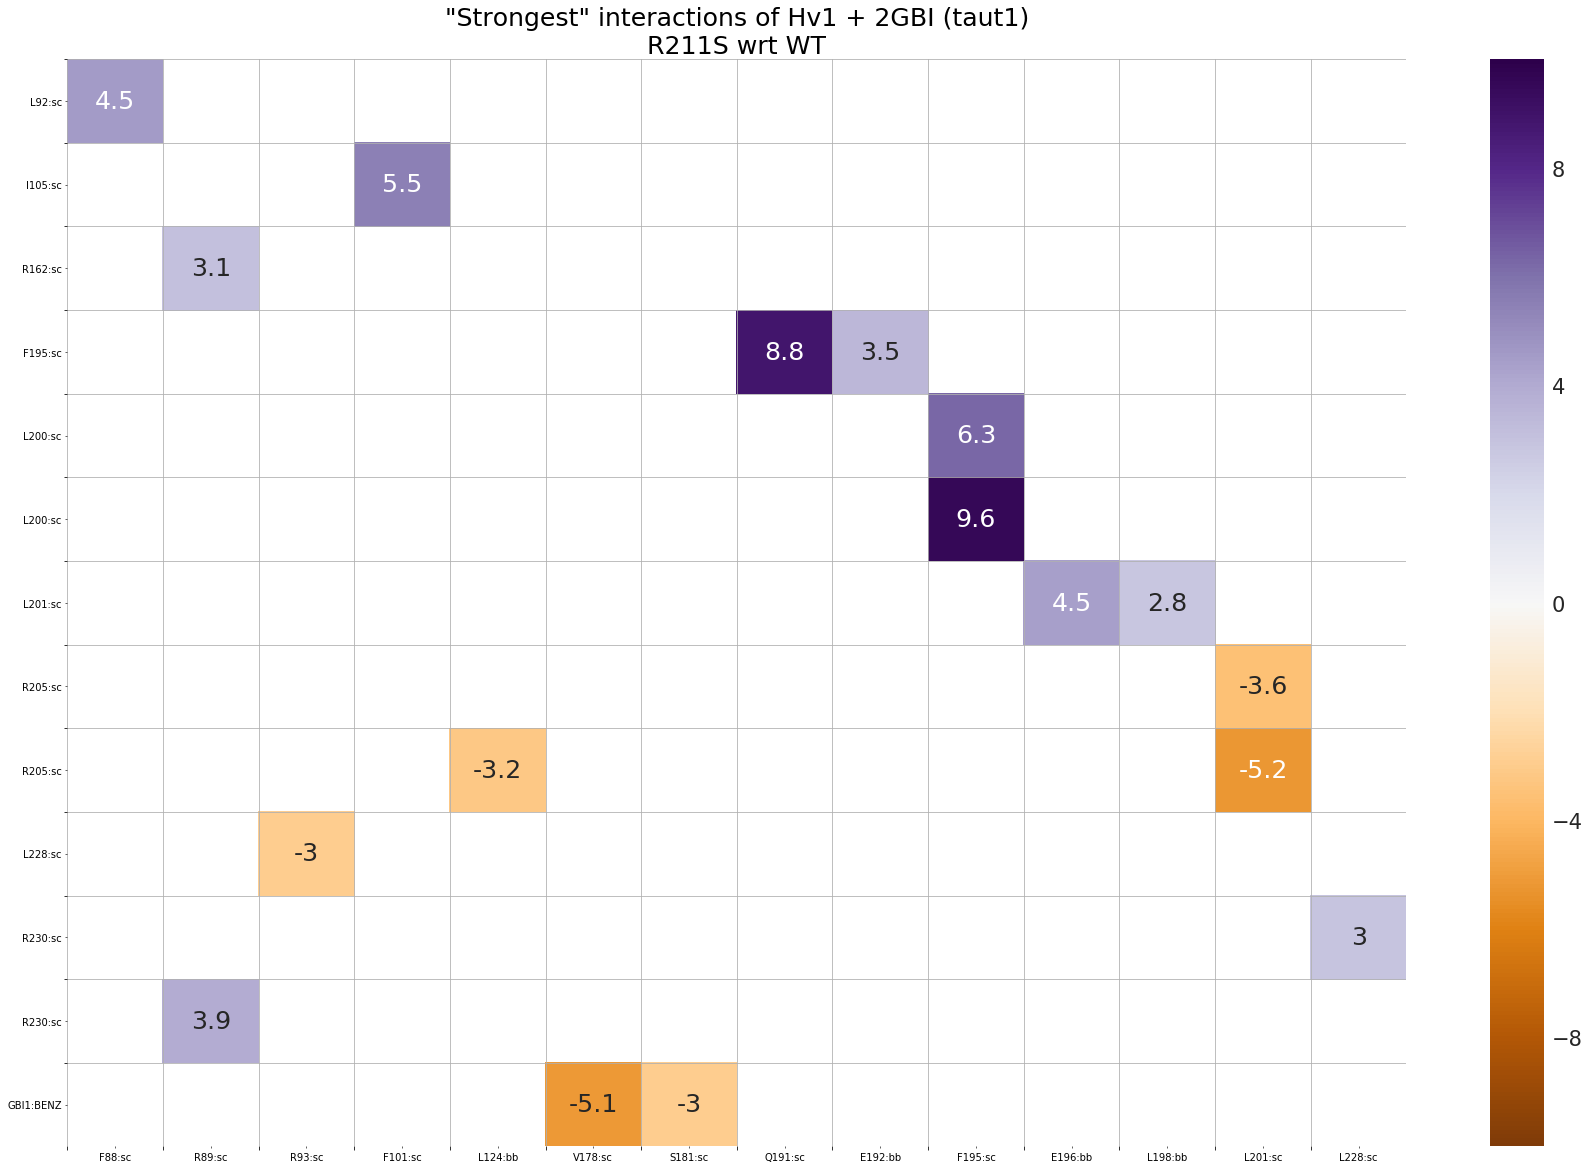

interaction range is from -10 to 10; verify if this is appropriate


In [18]:
pivot_diff_edges_1 = protLigInts(dry_diff_nodes_1, dry_diff_edges_1,rawNum=25,dry=2) # make sure you use REFERENCE nodes
plotHeatInts(dry_diff_nodes_1, pivot_diff_edges_1, minHeat=-10, maxHeat=10,colors='PuOr',size=(30,20),
             seltitle="Hv1 + 2GBI (taut1)\n{} wrt WT".format(mutcode))

### 2. Tautomer 2

In [19]:
diff_nodes_2, diff_edges_2, mutstart_2, offset_2 = diffEdges(nodes_2,wt_nodes_2,edges_2,wt_edges_2)
dry_diff_nodes_2, dry_diff_edges_2 = condenseWaters(diff_nodes_2, diff_edges_2)

nodes in 1st, not in 2nd:  [381 382 383 384]
nodes in 2nd, not in 1st:  [381 382 383]
Shifting node indices by 1 for 809198 rows


/mnt/c/Users/limtv/Documents/vtl_programs/miniconda3/envs/oepython3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/c/Users/limtv/Documents/vtl_programs/miniconda3/envs/oepython3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The water indices range from 447 to 11227
The new index of the summed waters is 11231


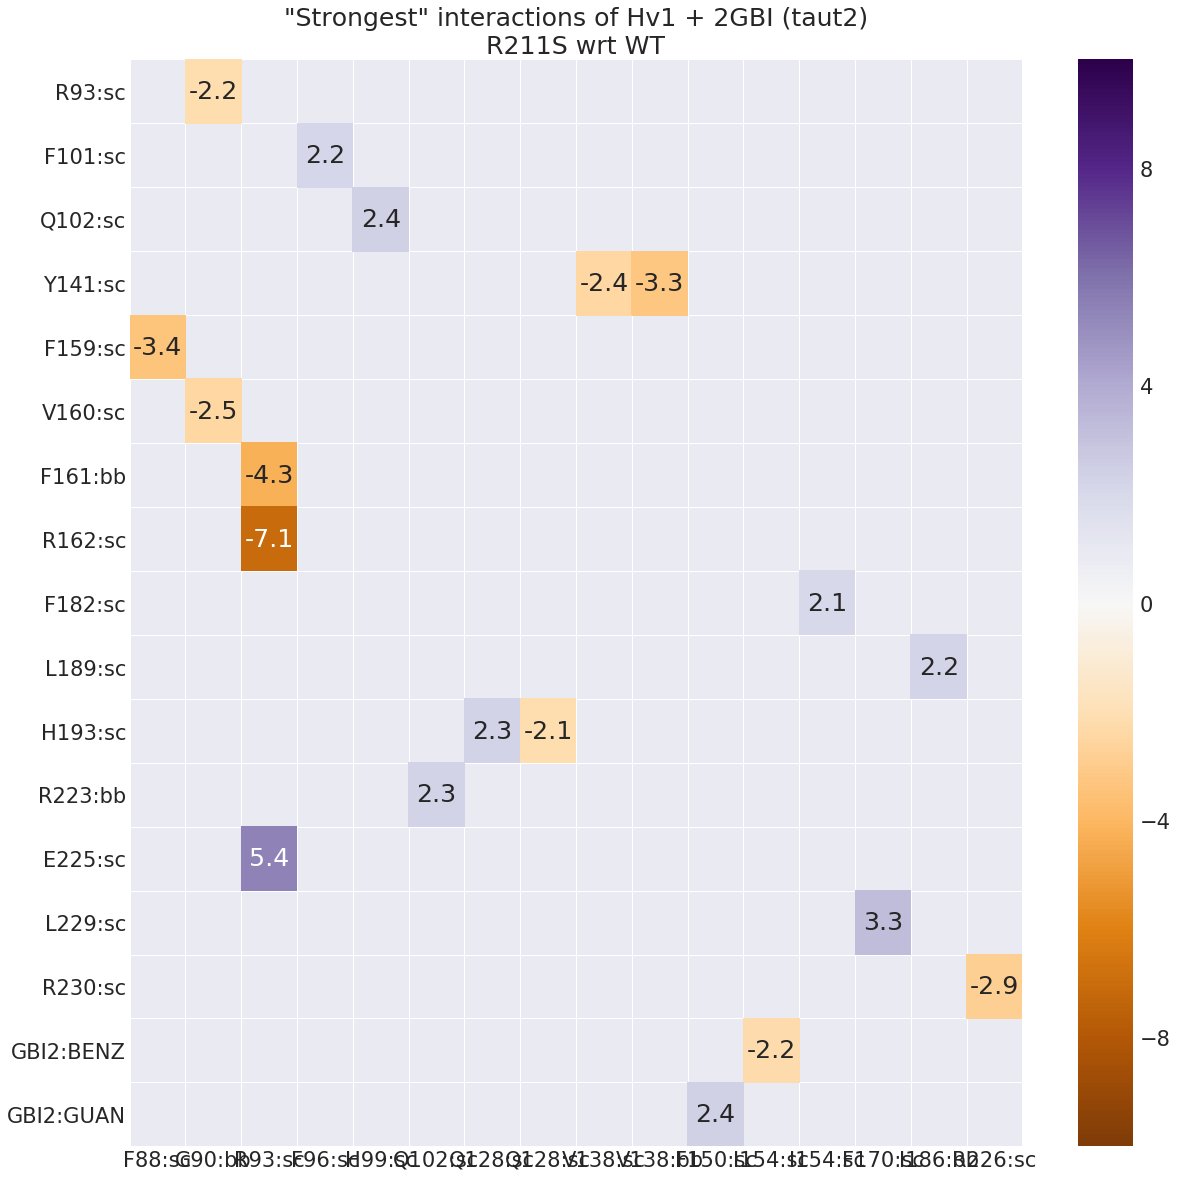

interaction range is from -10 to 10; verify if this is appropriate


In [20]:
pivot_diff_edges_2 = protLigInts(dry_diff_nodes_2, dry_diff_edges_2,rawNum=25,dry=2) # make sure you use REFERENCE nodes
plotHeatInts(dry_diff_nodes_2, pivot_diff_edges_2, minHeat=-10, maxHeat=10,colors='PuOr',
             seltitle="Hv1 + 2GBI (taut2)\n{} wrt WT".format(mutcode))

### 3. No ligand

In [21]:
diff_nodes_0, diff_edges_0, mutstart_0, offset_0 = diffEdges(nodes_0,wt_nodes_0,edges_0,wt_edges_0)
dry_diff_nodes_0, dry_diff_edges_0 = condenseWaters(diff_nodes_0, diff_edges_0)

nodes in 1st, not in 2nd:  [381 382 383 384]
nodes in 2nd, not in 1st:  [381 382 383]
Shifting node indices by 1 for 750971 rows


/mnt/c/Users/limtv/Documents/vtl_programs/miniconda3/envs/oepython3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/c/Users/limtv/Documents/vtl_programs/miniconda3/envs/oepython3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The water indices range from 447 to 11234
The new index of the summed waters is 11235


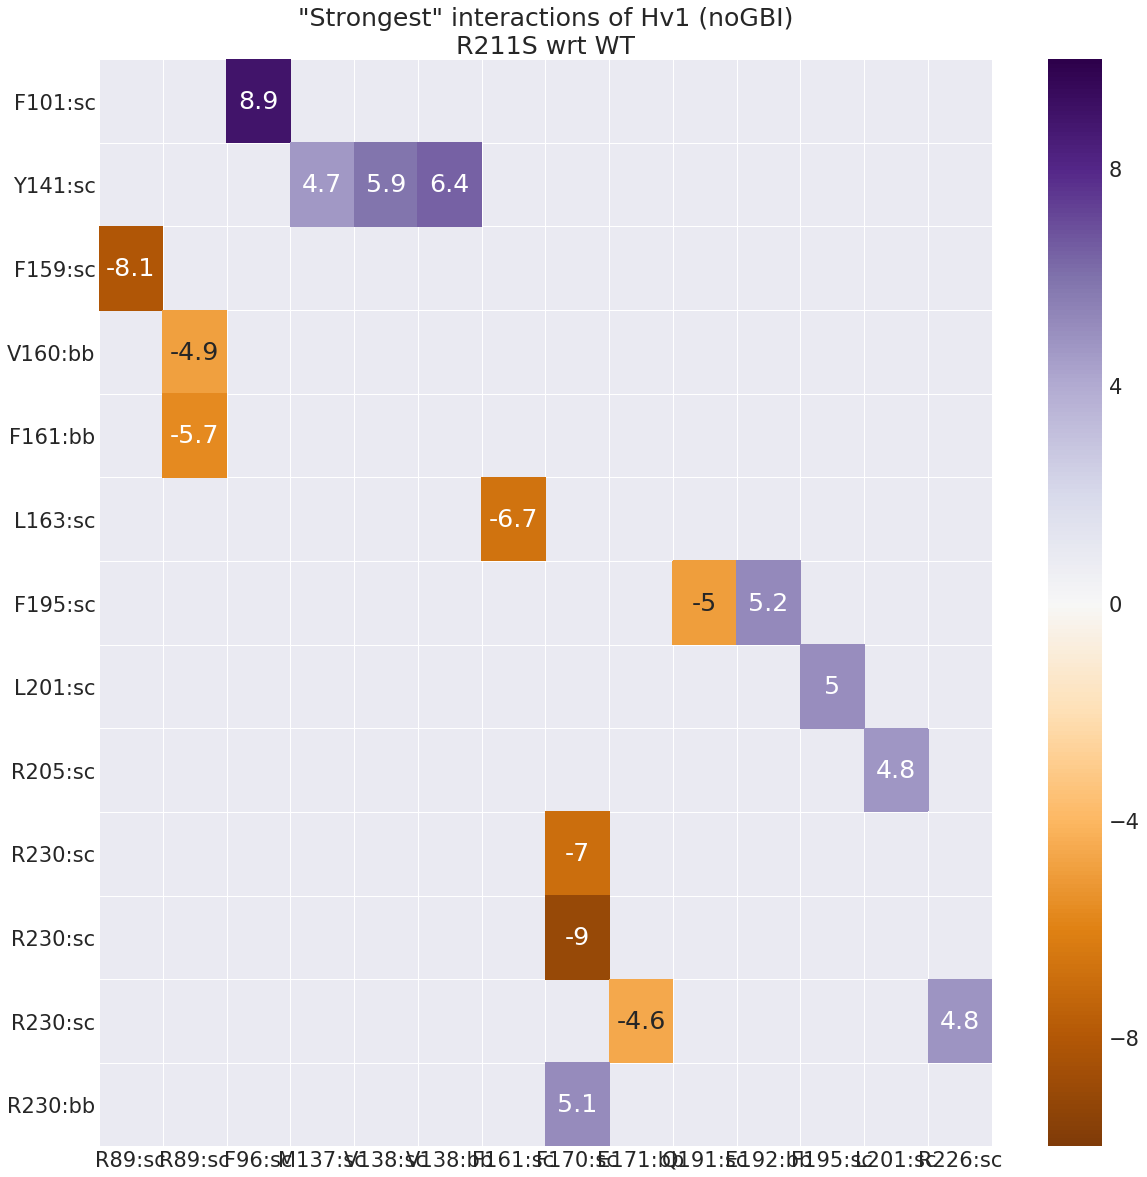

interaction range is from -10 to 10; verify if this is appropriate


In [22]:
pivot_diff_edges_0 = protLigInts(dry_diff_nodes_0, dry_diff_edges_0,rawNum=25,dry=2) # make sure you use REFERENCE nodes
plotHeatInts(dry_diff_nodes_0, pivot_diff_edges_0, minHeat=-10, maxHeat=10,colors='PuOr',
             seltitle="Hv1 (noGBI)\n{} wrt WT".format(mutcode))

## B. Focus on ligand-specific interactions

### 1. Tautomer 1

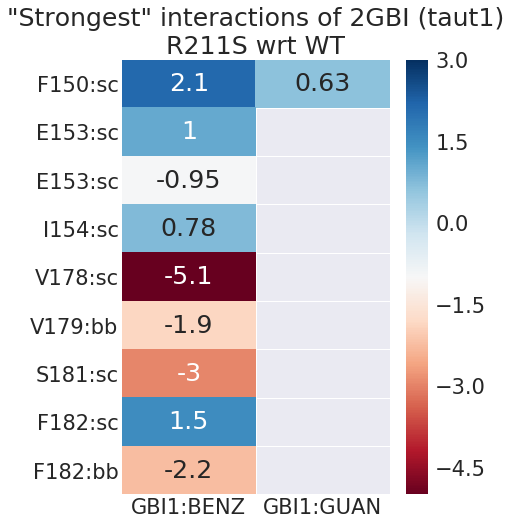

interaction range is from -5 to 3; verify if this is appropriate


In [23]:
# taut1 analysis (after-before) mutation
diff_gidx_1 = diff_nodes_1.index[diff_nodes_1['resname'] == 'GBI1'].tolist()
pivot_diff_gbi1_edges = selectionInts(dry_diff_nodes_1, dry_diff_edges_1, diff_gidx_1,rawNum=10)
plotHeatInts(dry_diff_nodes_1,pivot_diff_gbi1_edges,minHeat=-5,maxHeat=3,colors="RdBu",size=(6,8),
             seltitle='2GBI (taut1)\n{} wrt WT'.format(mutcode))

In [24]:
# taut1 analysis after mutation
gidx_1 = nodes_1.index[nodes_1['resname'] == 'GBI1'].tolist()
mut_gbi1_edges = selectionInts(nodes_1, edges_1, gidx_1,rawNum=1000)

In [25]:
# taut1 analysis before mutation
wt_gidx_1 = wt_nodes_1.index[wt_nodes_1['resname'] == 'GBI1'].tolist()
wild_gbi1_edges = selectionInts(wt_nodes_1, wt_edges_1, wt_gidx_1,rawNum=1000)

node_i's in common:  [11232 11233]
node_j's in common:  [ 75  76  77 180 181 185 189 191 192 193 196 200 201 202 204 205 206 213
 214 282 285 288 289 291 292 293 296 300 301 302]


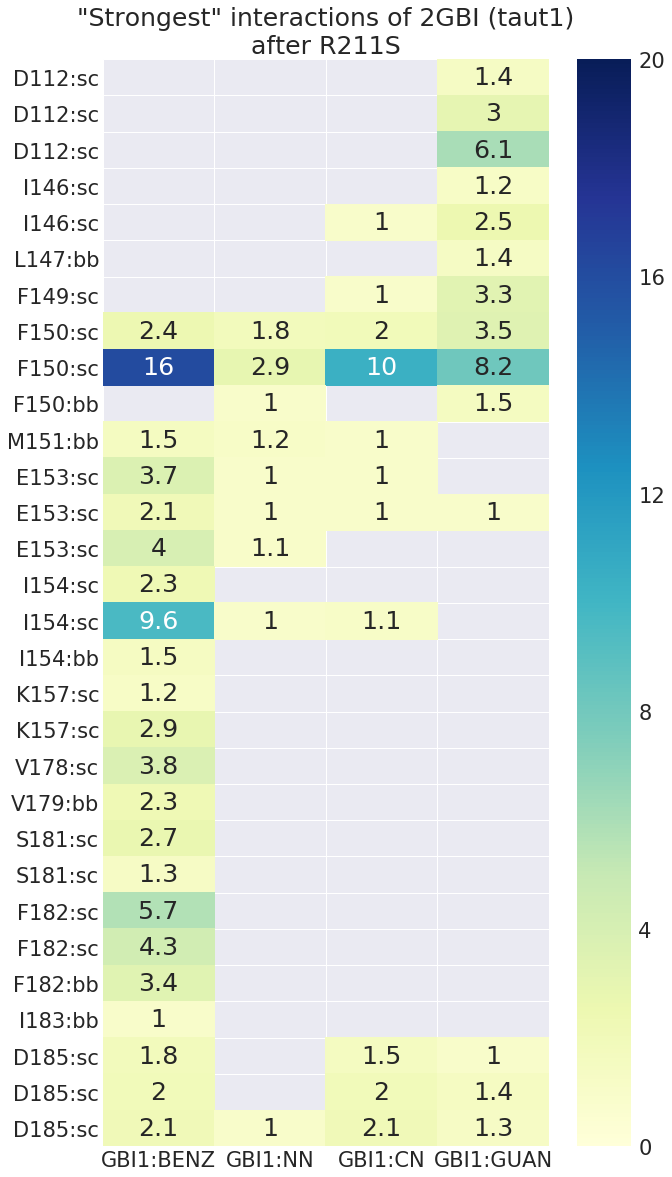

interaction range is from 0 to 20; verify if this is appropriate


In [26]:
# similarize edges before and after mutation
sim_mut_gbi1_edges, sim_wild_gbi1_edges = similarizeTwoEdges(mut_gbi1_edges, wild_gbi1_edges, mutstart=381, offset=1)
plotHeatInts(nodes_1,sim_mut_gbi1_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),
             seltitle='2GBI (taut1)\nafter {}'.format(mutcode))

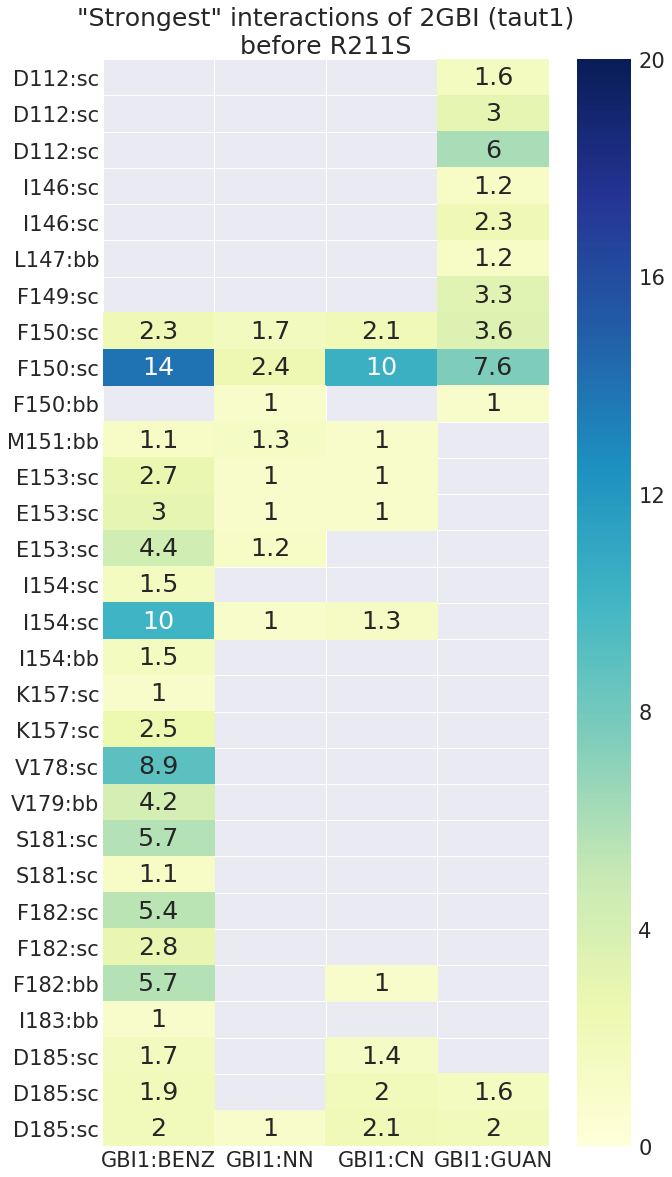

interaction range is from 0 to 20; verify if this is appropriate


In [27]:
plotHeatInts(wt_nodes_1,sim_wild_gbi1_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),
             seltitle='2GBI (taut1)\nbefore {}'.format(mutcode))

### 2. Tautomer 2

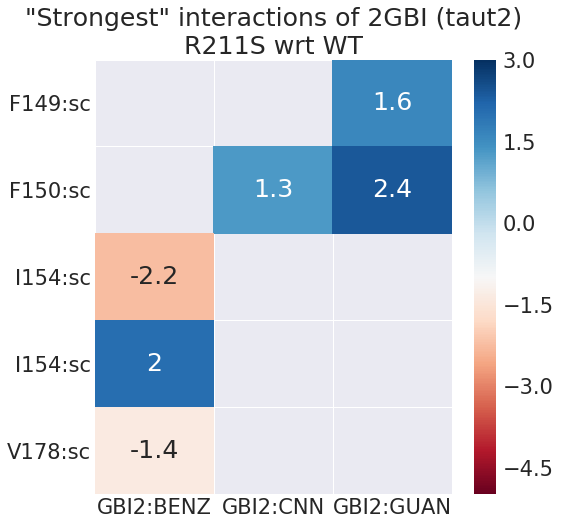

interaction range is from -5 to 3; verify if this is appropriate


In [28]:
# taut2 analysis (after-before) mutation
diff_gidx_2 = diff_nodes_2.index[diff_nodes_2['resname'] == 'GBI2'].tolist()
pivot_diff_gbi2_edges = selectionInts(diff_nodes_2, diff_edges_2, diff_gidx_2,rawNum=6)
plotHeatInts(diff_nodes_2,pivot_diff_gbi2_edges,minHeat=-5,maxHeat=3,colors="RdBu",size=(8,8),
             seltitle='2GBI (taut2)\n{} wrt WT'.format(mutcode))

In [29]:
# taut2 analysis after mutation
gidx_2 = nodes_2.index[nodes_2['resname'] == 'GBI2'].tolist()
mut_gbi2_edges = selectionInts(nodes_2, edges_2, gidx_2,rawNum=1000)

In [30]:
# taut2 analysis before mutation
wt_gidx_2 = wt_nodes_2.index[wt_nodes_2['resname'] == 'GBI2'].tolist()
wild_gbi2_edges = selectionInts(wt_nodes_2, wt_edges_2, wt_gidx_2,rawNum=1000)

node_i's in common:  [11229]
node_j's in common:  [ 75  76  77 180 181 185 189 191 192 193 196 200 201 202 204 205 206 214
 215 282 285 288 289 291 292 293 296 300 301 302]


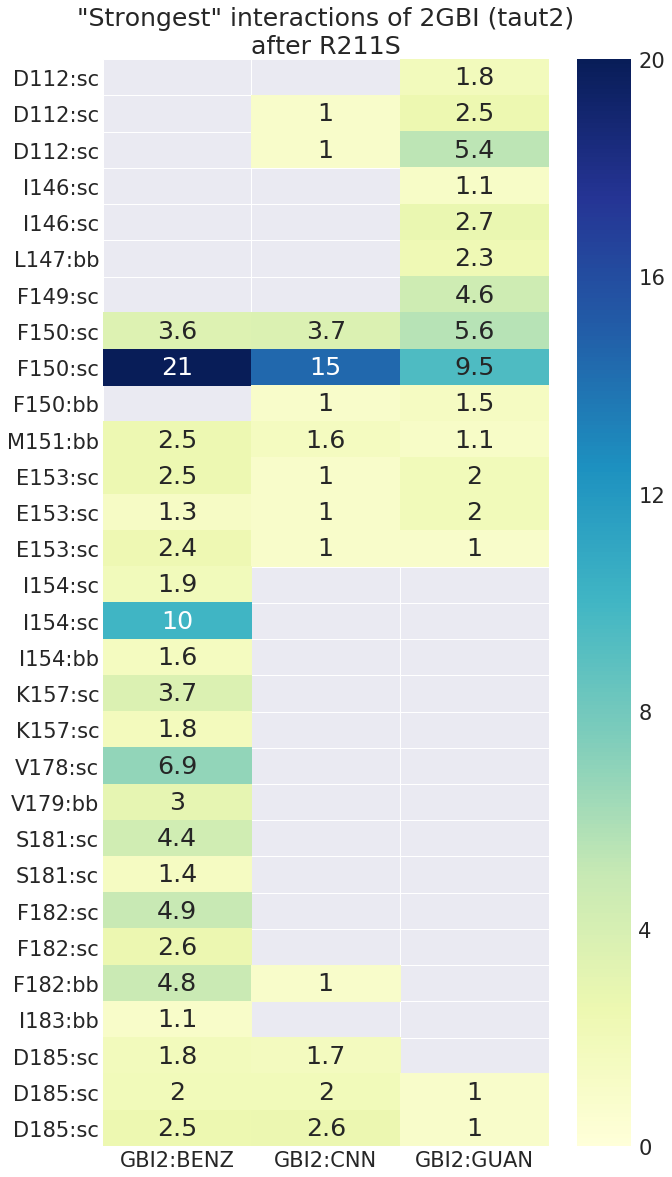

interaction range is from 0 to 20; verify if this is appropriate


In [31]:
# similarize edges before and after mutation
sim_mut_gbi2_edges, sim_wild_gbi2_edges = similarizeTwoEdges(mut_gbi2_edges, wild_gbi2_edges, mutstart=381, offset=1)
plotHeatInts(nodes_2,sim_mut_gbi2_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),
             seltitle='2GBI (taut2)\nafter {}'.format(mutcode))

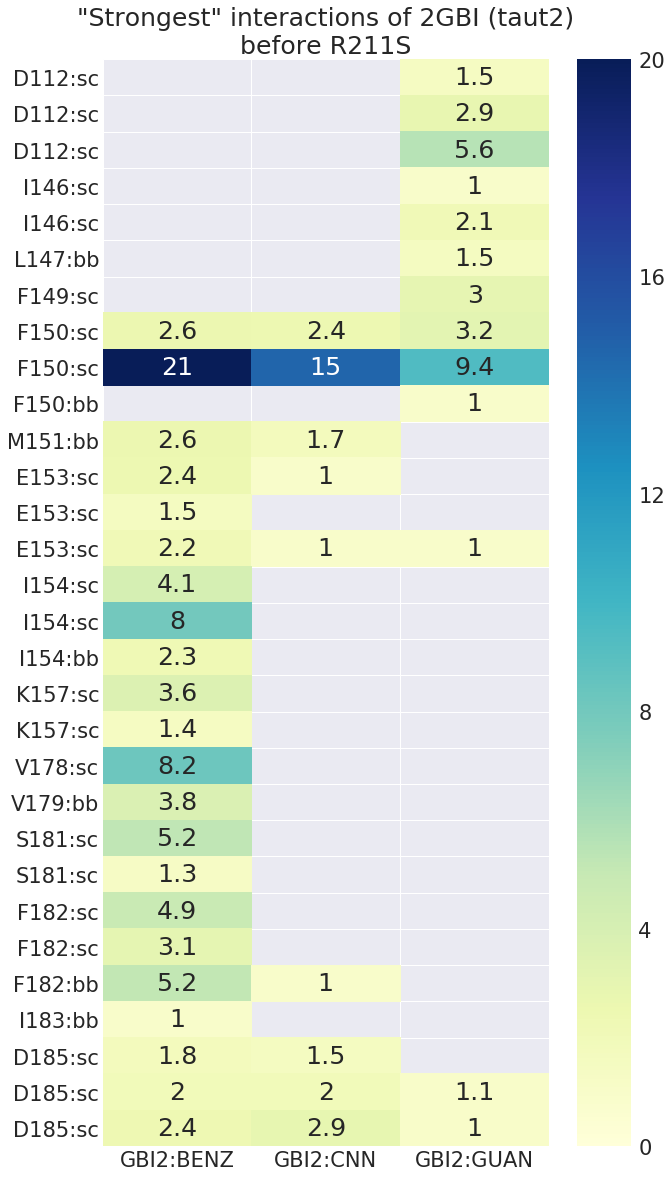

interaction range is from 0 to 20; verify if this is appropriate


In [32]:
plotHeatInts(wt_nodes_2,sim_wild_gbi2_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),
             seltitle='2GBI (taut2)\nbefore {}'.format(mutcode))

### 3. No ligand

[placeholder]

## C. Focus on relative hydration by residue

### 1. Tautomer 1

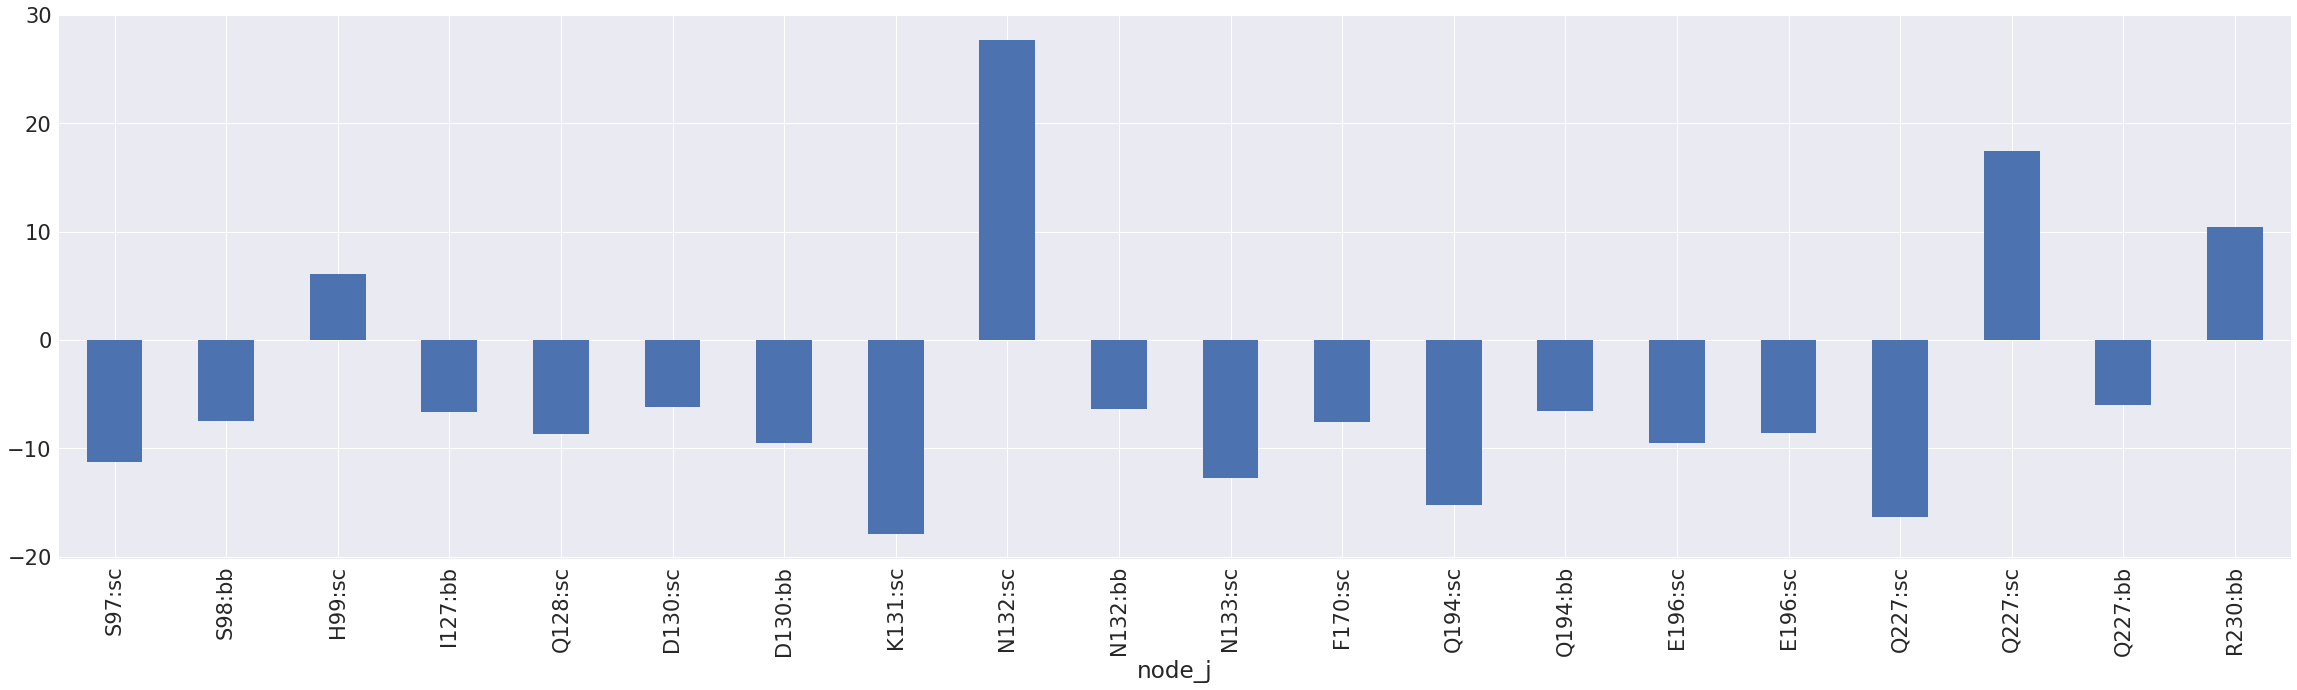

In [33]:
waterEdges_1 = plotBarWaters(dry_diff_nodes_1, dry_diff_edges_1)

### 2. Tautomer 2

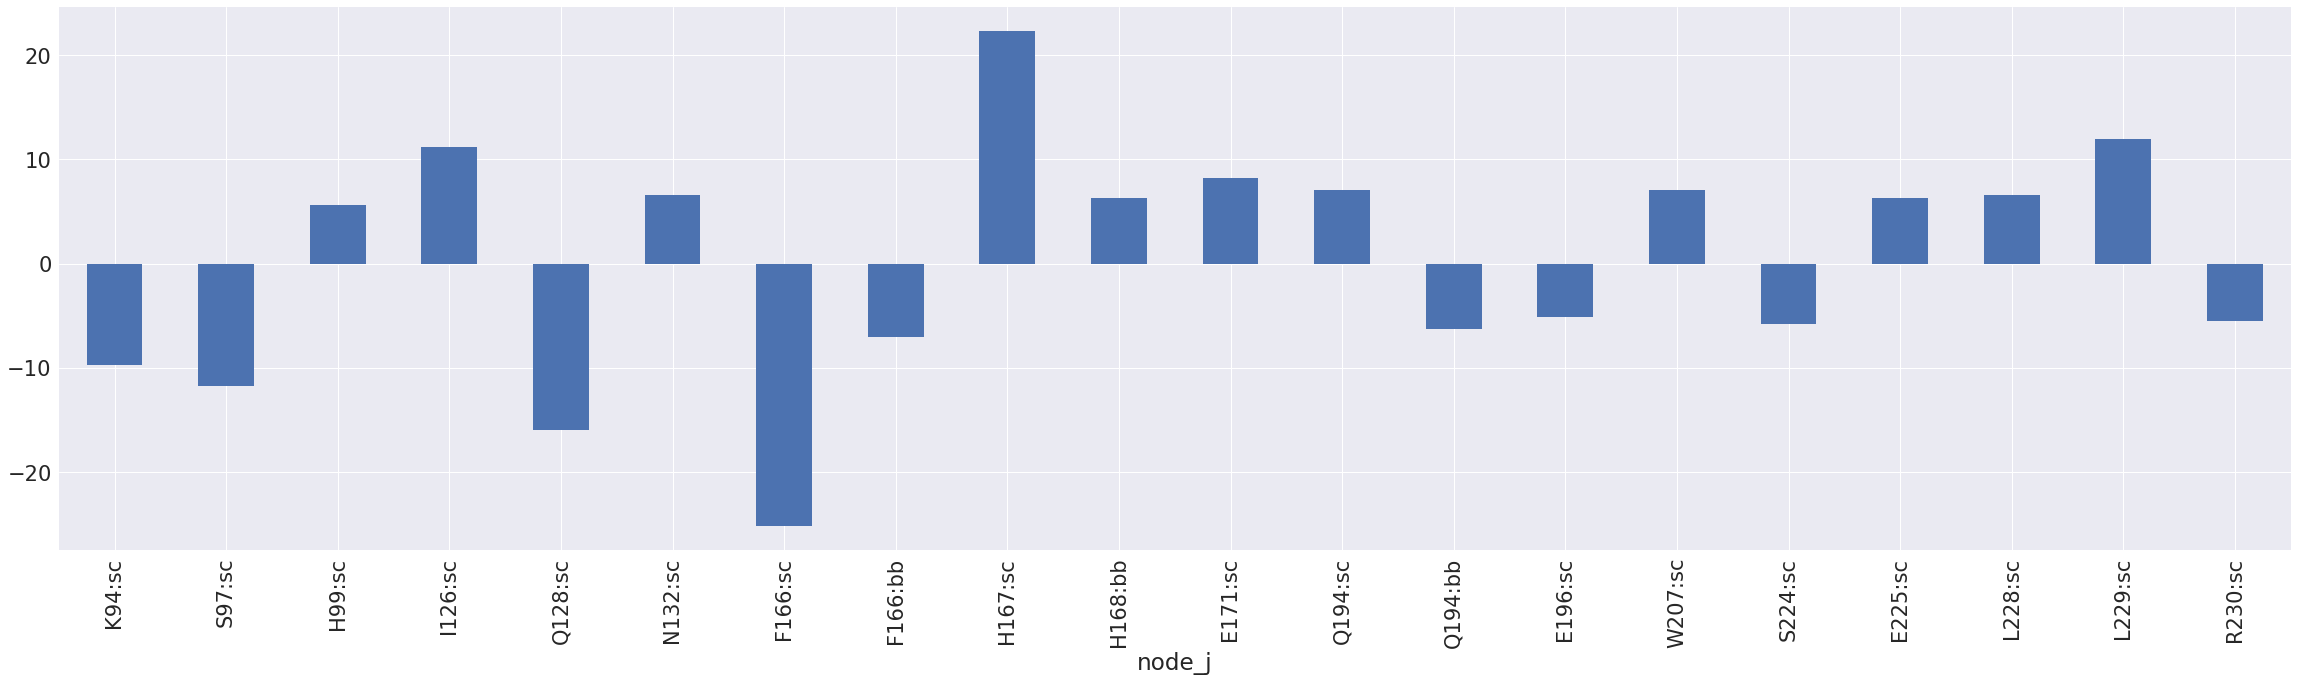

In [34]:
waterEdges_2 = plotBarWaters(dry_diff_nodes_2, dry_diff_edges_2)

### 3. Both tautomers in common

In [35]:
sim_waterEdges_1, sim_waterEdges_2 = similarizeTwoEdges(waterEdges_1, waterEdges_2)

node_i's in common:  []
node_j's in common:  [ 30  39 125 138 331 332 338]


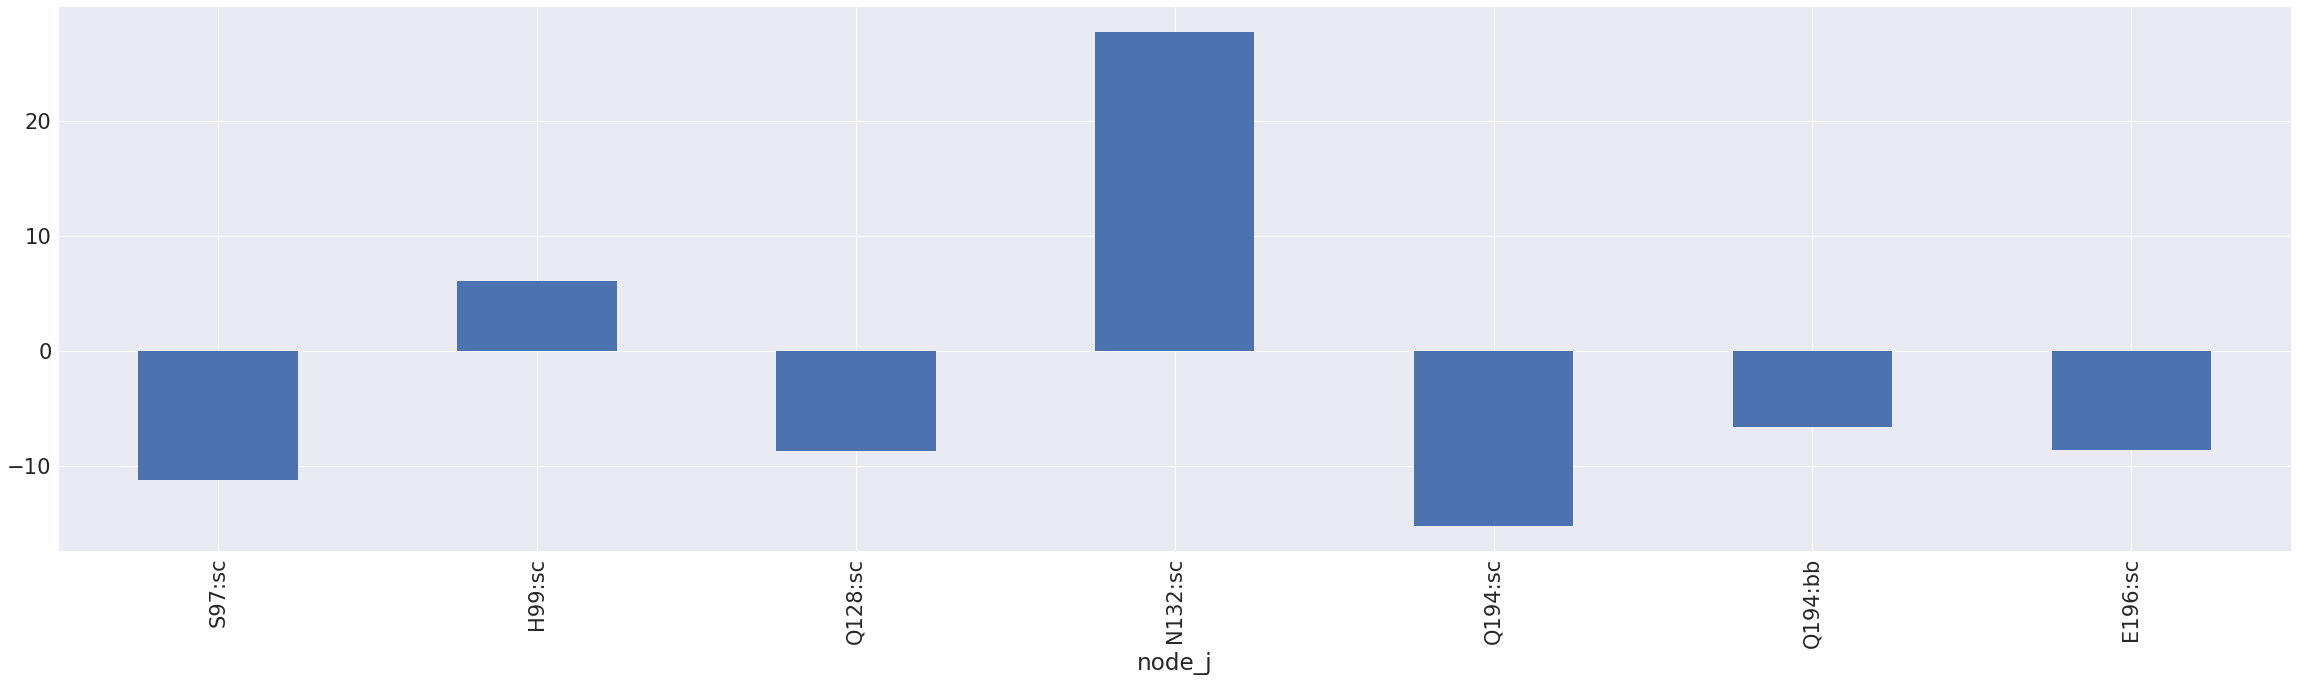

In [36]:
_ = plotBarWaters(dry_diff_nodes_1, sim_waterEdges_1, pivoted=True)

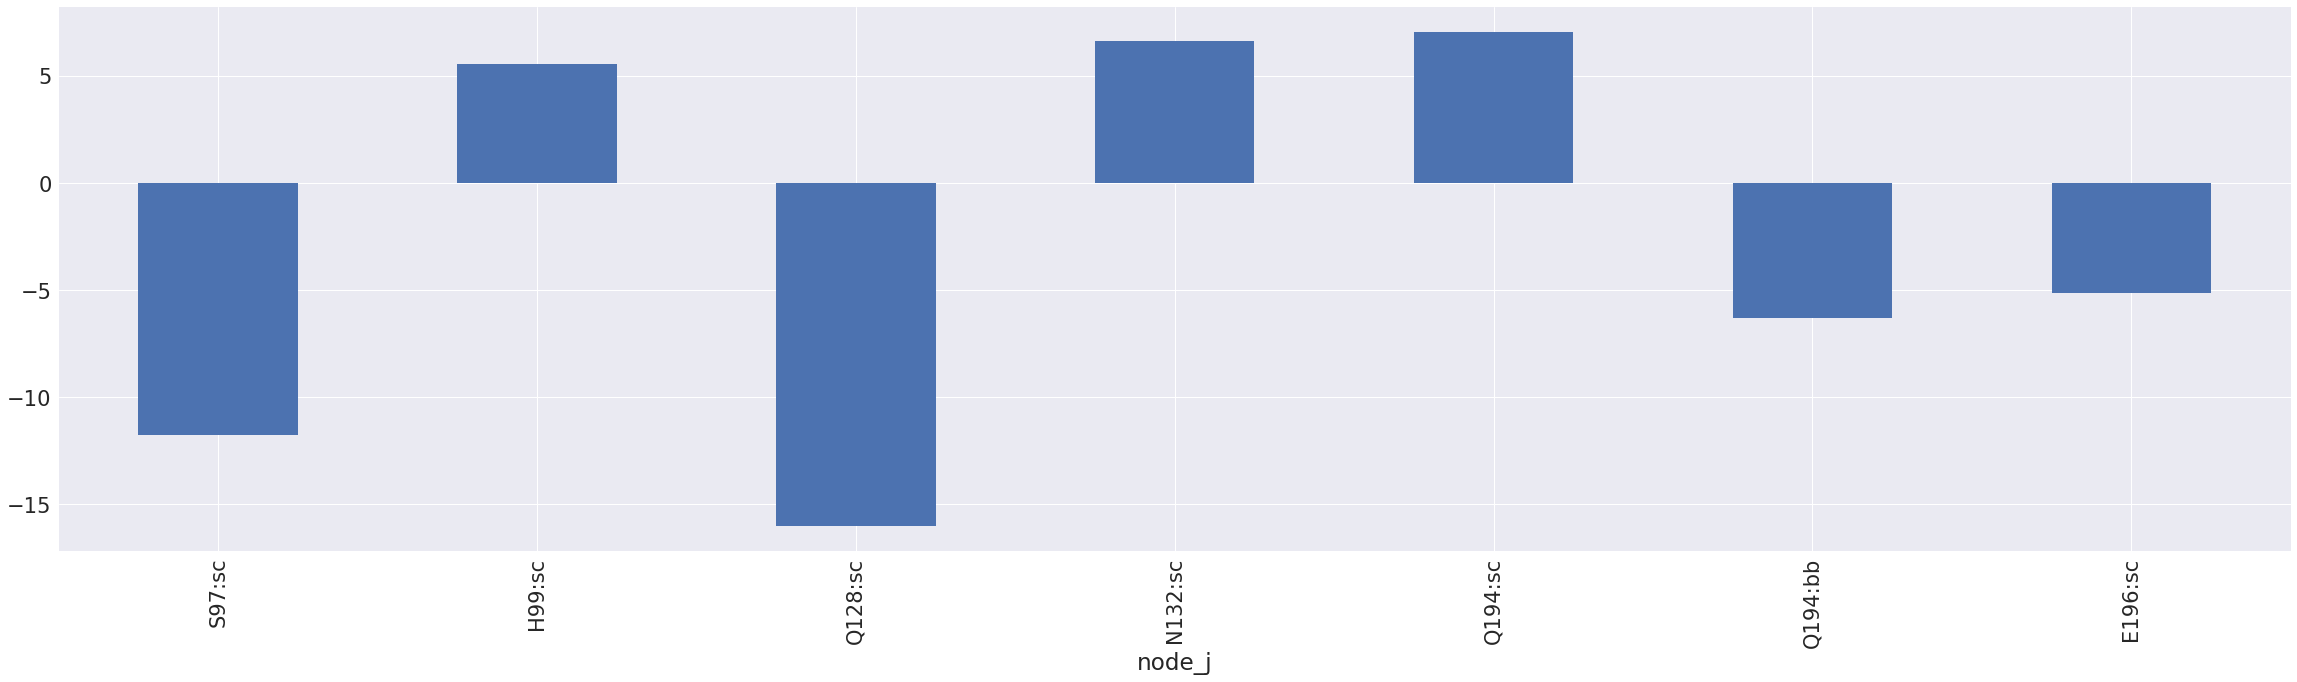

In [37]:
_ = plotBarWaters(dry_diff_nodes_2, sim_waterEdges_2, pivoted=True)

### 4. Verify hydration in edges
Verify that some residue does see the given change in water interactions.  
Not exact because the protein sidechain plotted in the heat map doesn't specify which node in residue.  
Fill in:
1. Node indices range, from getResidInfo (don't forget to add one to upper range)
2. Lower water index, from output of condenseWaters
3. Upper water index, from output of condenseWaters
4. 'average' or 'avg_subt'

In [38]:
getResidInfo(128,nodes_2,resExcludes=['WAT'])

,resname,resid,location,type,code,nAtoms
index,,,,,,
124,GLN,128,sc,NOP,ABG,3
125,GLN,128,sc,DIP,DE,3
126,GLN,128,bb,DIP,BB,3


In [39]:
diff_edges_2[(diff_edges_2.node_i.isin(range(124,127))) & (diff_edges_2.node_j>447) & (diff_edges_2.node_j<11227)].avg_subt.sum()

-14.170382541435172

## D. Focus on other defined interactions

### 1. D112

In [40]:
# get and verify indices for after and before case (112 is before mutation)
selNodes_112 = getResidInfo(112, nodes_1, resExcludes=['WAT'])
d112idx_1 = selNodes_112.index.tolist()[:-1]
print(d112idx_1)
selNodes_112

[75, 76, 77]


,resname,resid,location,type,code,nAtoms
index,,,,,,
75,ASP,112,sc,NOP,AB,2
76,ASP,112,sc,NOP,G,1
77,ASP,112,sc,NEG,D,2
78,ASP,112,bb,DIP,BB,3


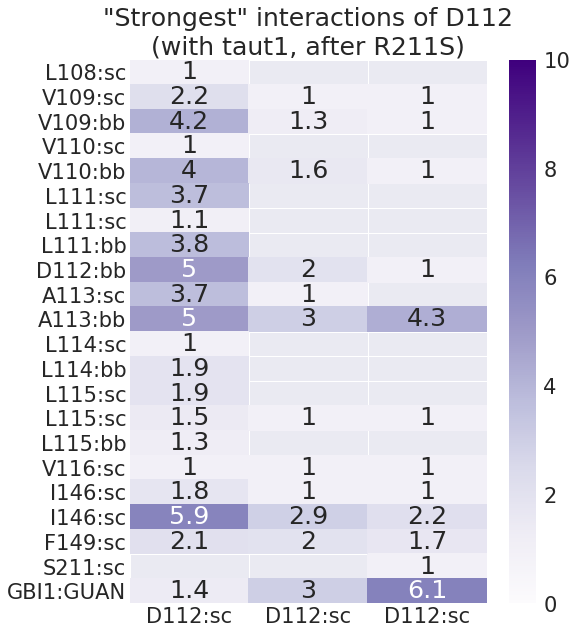

interaction range is from 0 to 10; verify if this is appropriate


node_j,65,68,69,70,71,72,73,74,78,79,...,83,84,85,86,87,180,181,189,382,11233
node_i,,,,,,,,,,,,,,,,,,,,,
75,1.0,2.211155,4.195219,1.015152,4.000000,3.737052,1.08642,3.780876,5.000000,3.729084,...,1.89243,1.944223,1.477064,1.252252,1.0,1.825532,5.948207,2.075117,NaN,1.375000
76,NaN,1.006579,1.276316,NaN,1.621212,NaN,NaN,NaN,2.000000,1.004049,...,NaN,NaN,1.000000,NaN,1.0,1.000000,2.940239,2.000000,NaN,3.000000
77,NaN,1.000000,1.000000,NaN,1.000000,NaN,NaN,NaN,1.007968,NaN,...,NaN,NaN,1.000000,NaN,1.0,1.000000,2.179283,1.693989,1.0,6.051793


In [41]:
# d112 after mutation
mut1_d112_edges = selectionInts(nodes_1, edges_1, d112idx_1, rawNum=200)
plotHeatInts(nodes_1,mut1_d112_edges,minHeat=0,maxHeat=10,colors="Purples",size=(8,10),
             seltitle='D112\n(with taut1, after {})'.format(mutcode))
mut1_d112_edges

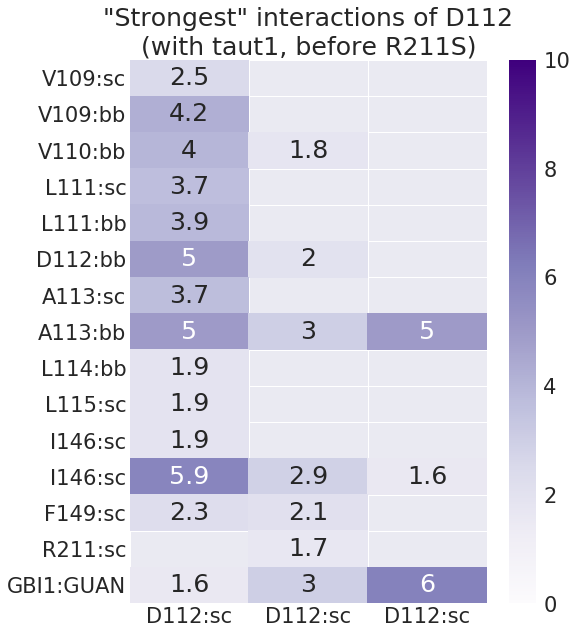

interaction range is from 0 to 10; verify if this is appropriate


node_j,68,69,71,72,74,78,79,80,83,84,180,181,189,383,11234
node_i,,,,,,,,,,,,,,,
75,2.468,4.24,4.000000,3.672,3.9,4.996,3.736,5.000,1.9,1.932,1.881857,5.916,2.302041,NaN,1.580488
76,NaN,NaN,1.799087,NaN,NaN,2.000,NaN,3.000,NaN,NaN,NaN,2.912,2.095833,1.666667,3.000000
77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.032,NaN,NaN,NaN,1.584,NaN,NaN,6.036000


In [42]:
# d112 before mutation
wt1_d112_edges = selectionInts(wt_nodes_1, wt_edges_1, d112idx_1, rawNum=25)
plotHeatInts(wt_nodes_1,wt1_d112_edges,minHeat=0,maxHeat=10,colors="Purples",size=(8,10),
             seltitle='D112\n(with taut1, before {})'.format(mutcode))
wt1_d112_edges

In [43]:
# get and verify indices for diff
diff_selNodes_112 = getResidInfo(112, diff_nodes_1, resExcludes=['WAT'])
diff_d112idx_1 = selNodes_112.index.tolist()[:-1]
print(diff_d112idx_1)
diff_selNodes_112

[75, 76, 77]


,resname,resid,location,type,code,nAtoms
index,,,,,,
75,ASP,112,sc,NOP,AB,2
76,ASP,112,sc,NOP,G,1
77,ASP,112,sc,NEG,D,2
78,ASP,112,bb,DIP,BB,3


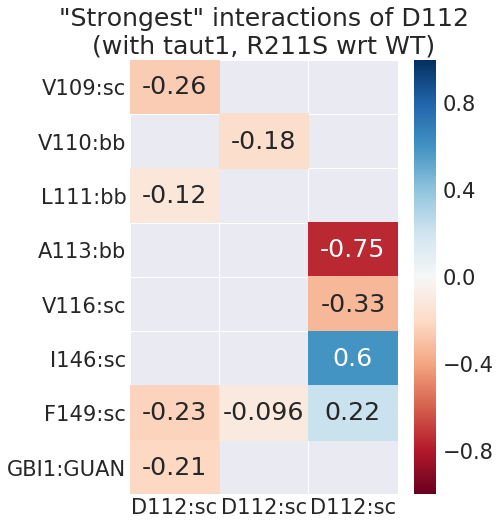

interaction range is from -1 to 1; verify if this is appropriate


node_j,68,71,74,80,87,181,189,11234
node_i,,,,,,,,
75,-0.256845,NaN,-0.119124,NaN,NaN,NaN,-0.226923,-0.205488
76,NaN,-0.177875,NaN,NaN,NaN,NaN,-0.095833,NaN
77,NaN,NaN,NaN,-0.753116,-0.333333,0.595283,0.219413,NaN


In [44]:
# d112 analysis (after-before) mutation
pivot1_diff_d112_edges = selectionInts(dry_diff_nodes_1, dry_diff_edges_1, diff_d112idx_1, rawNum=10)
plotHeatInts(dry_diff_nodes_1,pivot1_diff_d112_edges,minHeat=-1,maxHeat=1,colors="RdBu",size=(6,8),
             seltitle='D112\n(with taut1, {} wrt WT)'.format(mutcode))
pivot1_diff_d112_edges

### 2. D185

In [45]:
# get and verify indices for after and before case (185 is before mutation)
selNodes_185 = getResidInfo(185, nodes_1, resExcludes=['WAT'])
d185idx_1 = selNodes_185.index.tolist()[:-1]
print(d185idx_1)
selNodes_185

[300, 301, 302]


,resname,resid,location,type,code,nAtoms
index,,,,,,
300,ASP,185,sc,NOP,AB,2
301,ASP,185,sc,NOP,G,1
302,ASP,185,sc,NEG,D,2
303,ASP,185,bb,DIP,BB,3


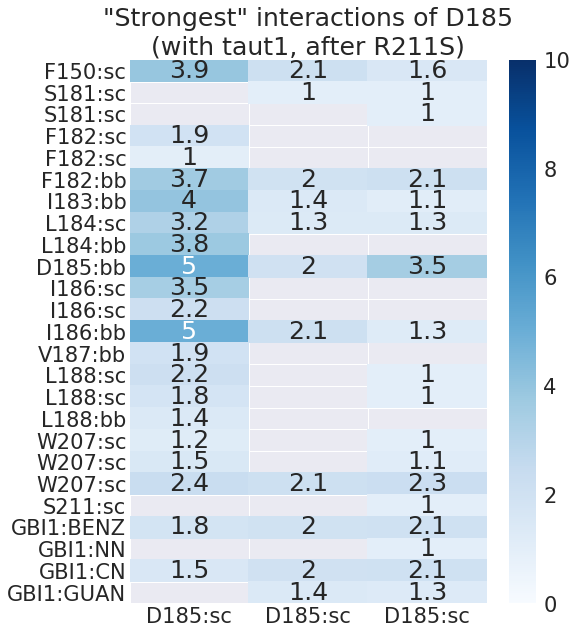

interaction range is from 0 to 10; verify if this is appropriate


node_j,192,288,289,291,292,293,296,297,299,303,...,310,311,369,370,371,382,11230,11231,11232,11233
node_i,,,,,,,,,,,,,,,,,,,,,
300,3.927711,NaN,NaN,1.948207,1.022222,3.663968,4.000000,3.215139,3.792829,5.000000,...,1.794286,1.417582,1.196721,1.485597,2.364444,NaN,1.810945,NaN,1.540404,NaN
301,2.113636,1.0,NaN,NaN,NaN,1.988048,1.444976,1.340909,NaN,2.015936,...,NaN,NaN,NaN,NaN,2.119522,NaN,1.968127,NaN,1.996016,1.428571
302,1.560345,1.0,1.0,NaN,NaN,2.132000,1.100000,1.333333,NaN,3.525896,...,1.000000,NaN,1.000000,1.135458,2.262948,1.0,2.063745,1.0,2.063745,1.326531


In [46]:
# d185 after mutation
mut1_d185_edges = selectionInts(nodes_1, edges_1, d185idx_1, rawNum=50)
plotHeatInts(nodes_1,mut1_d185_edges,minHeat=0,maxHeat=10,colors="Blues",size=(8,10),
             seltitle='D185\n(with taut1, after {})'.format(mutcode))
mut1_d185_edges

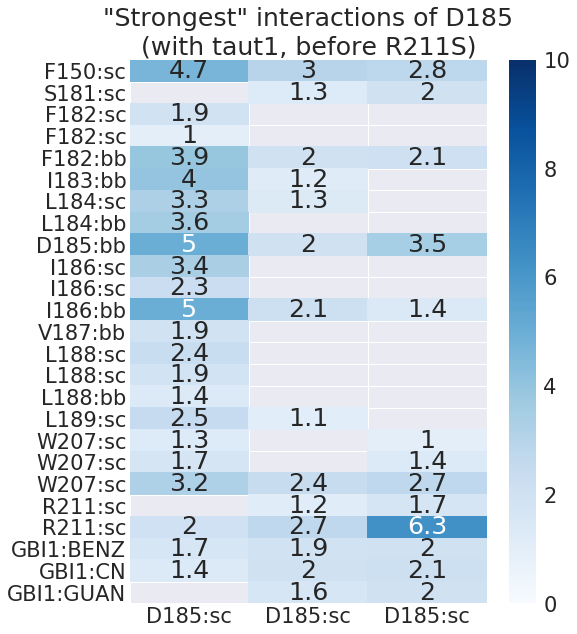

interaction range is from 0 to 10; verify if this is appropriate


node_j,192,288,291,292,293,296,297,299,303,304,...,311,313,369,370,371,382,383,11231,11233,11234
node_i,,,,,,,,,,,,,,,,,,,,,
300,4.680000,NaN,1.915663,1.032258,3.912000,4.000000,3.284000,3.56,5.000,3.364,...,1.376884,2.513699,1.324,1.708,3.218884,NaN,2.031579,1.673611,1.370079,NaN
301,2.983740,1.307692,NaN,NaN,2.000000,1.220588,1.329545,NaN,2.012,NaN,...,NaN,1.100000,NaN,NaN,2.408000,1.156,2.716000,1.936000,2.000000,1.60241
302,2.781991,2.000000,NaN,NaN,2.080972,NaN,NaN,NaN,3.512,NaN,...,NaN,NaN,1.008,1.372,2.704000,1.740,6.288000,1.960000,2.116000,1.95600


In [47]:
# d185 before mutation
wt1_d185_edges = selectionInts(wt_nodes_1, wt_edges_1, d185idx_1, rawNum=50)
plotHeatInts(wt_nodes_1,wt1_d185_edges,minHeat=0,maxHeat=10,colors="Blues",size=(8,10),
             seltitle='D185\n(with taut1, before {})'.format(mutcode))
wt1_d185_edges

In [48]:
# get and verify indices for diff
diff_selNodes_185 = getResidInfo(185, diff_nodes_1, resExcludes=['WAT'])
diff_d185idx_1 = selNodes_185.index.tolist()[:-1]
print(diff_d185idx_1)
diff_selNodes_185

[300, 301, 302]


,resname,resid,location,type,code,nAtoms
index,,,,,,
300,ASP,185,sc,NOP,AB,2
301,ASP,185,sc,NOP,G,1
302,ASP,185,sc,NEG,D,2
303,ASP,185,bb,DIP,BB,3


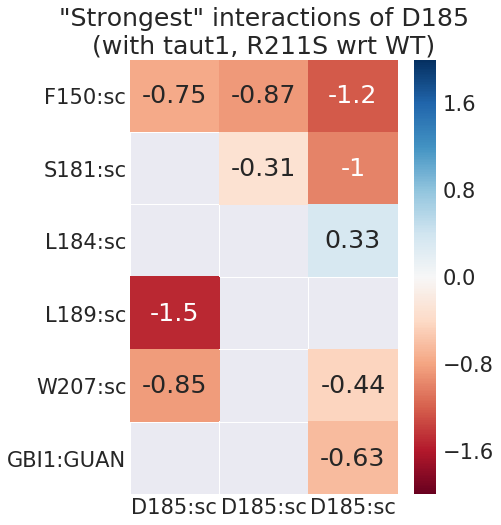

interaction range is from -2 to 2; verify if this is appropriate


node_j,192,288,297,313,371,11234
node_i,,,,,,
300,-0.752289,NaN,NaN,-1.513699,-0.854440,NaN
301,-0.870103,-0.307692,NaN,NaN,NaN,NaN
302,-1.221646,-1.000000,0.333333,NaN,-0.441052,-0.629469


In [49]:
# d185 analysis (after-before) mutation
pivot1_diff_d185_edges = selectionInts(dry_diff_nodes_1, dry_diff_edges_1, diff_d185idx_1, rawNum=10)
plotHeatInts(dry_diff_nodes_1,pivot1_diff_d185_edges,minHeat=-2,maxHeat=2,colors="RdBu",size=(6,8),
             seltitle='D185\n(with taut1, {} wrt WT)'.format(mutcode))
pivot1_diff_d185_edges

### 3. R211

In [50]:
# get and verify indices for AFTER
selNodes_211 = getResidInfo(211, nodes_1, resExcludes=['WAT'])
r211idx_1 = selNodes_211.index.tolist()[:-1]
print(r211idx_1)
selNodes_211

[381, 382]


,resname,resid,location,type,code,nAtoms
index,,,,,,
381,SER,211,sc,NOP,AB,2
382,SER,211,sc,DIP,G,1
383,SER,211,bb,DIP,BB,3


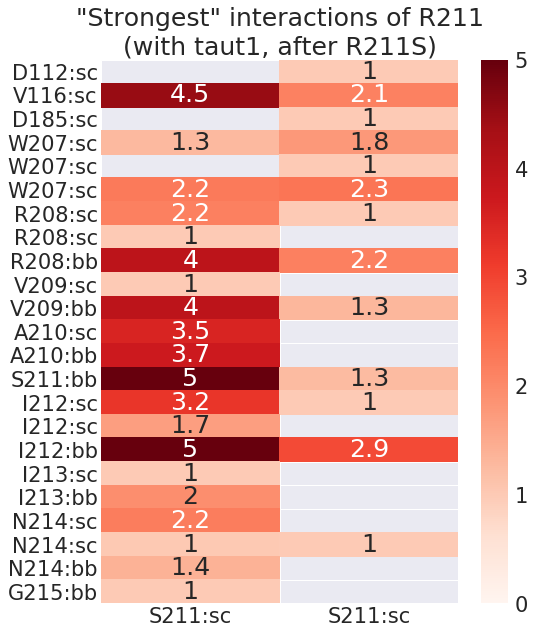

interaction range is from 0 to 5; verify if this is appropriate


node_j,77,87,302,369,370,371,373,374,376,377,...,383,384,385,386,387,389,390,391,392,394
node_i,,,,,,,,,,,,,,,,,,,,,
381,NaN,4.498008,NaN,1.285714,NaN,2.250000,2.155378,1.0,3.996016,1.0,...,5.000000,3.231076,1.692982,5.000000,1.0,1.952191,2.195219,1.03125,1.396104,1.0
382,1.0,2.143519,1.0,1.792453,1.0,2.333333,1.000000,NaN,2.153061,NaN,...,1.266932,1.000000,NaN,2.920319,NaN,NaN,NaN,1.00000,NaN,NaN


In [51]:
# r211 after mutation
mut1_r211_edges = selectionInts(nodes_1, edges_1, r211idx_1, rawNum=200)
plotHeatInts(nodes_1,mut1_r211_edges,minHeat=0,maxHeat=5,colors="Reds",size=(8,10),
             seltitle='R211\n(with taut1, after {})'.format(mutcode))
mut1_r211_edges

In [52]:
# get and verify indices for BEFORE
selNodes_211 = getResidInfo(211, wt_nodes_1, resExcludes=['WAT'])
r211idx_1 = selNodes_211.index.tolist()[:-1]
print(r211idx_1)
selNodes_211

[381, 382, 383]


,resname,resid,location,type,code,nAtoms
index,,,,,,
381,ARG,211,sc,NOP,AB,2
382,ARG,211,sc,NOP,GD,2
383,ARG,211,sc,POS,EZ,4
384,ARG,211,bb,DIP,BB,3


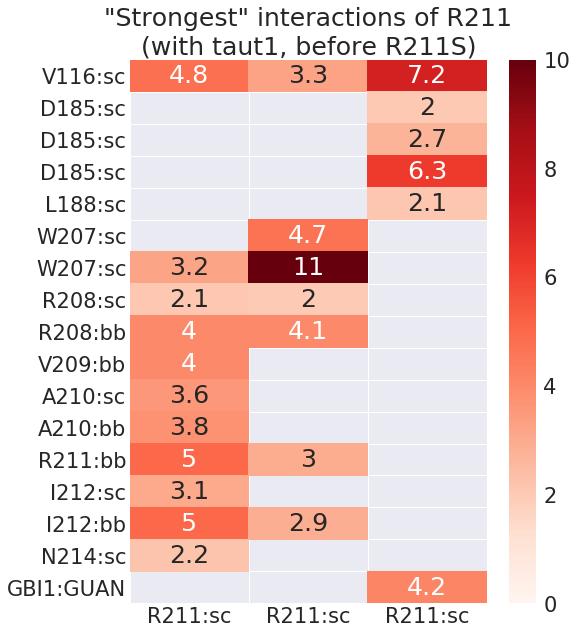

interaction range is from 0 to 10; verify if this is appropriate


node_j,87,300,301,302,310,369,371,373,376,378,379,380,384,385,387,391,11234
node_i,,,,,,,,,,,,,,,,,
381,4.828000,NaN,NaN,NaN,NaN,NaN,3.215686,2.088000,4.000,4.0,3.576,3.776,5.000,3.072,5.0,2.2,NaN
382,3.269076,NaN,NaN,NaN,NaN,4.7,11.312000,2.012146,4.052,NaN,NaN,NaN,2.964,NaN,2.9,NaN,NaN
383,7.208000,2.031579,2.716,6.288,2.116466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.169355


In [53]:
# r211 before mutation
wt1_r211_edges = selectionInts(wt_nodes_1, wt_edges_1, r211idx_1, rawNum=25)
plotHeatInts(wt_nodes_1,wt1_r211_edges,minHeat=0,maxHeat=10,colors="Reds",size=(8,10),
             seltitle='R211\n(with taut1, before {})'.format(mutcode))
wt1_r211_edges

# III. Analyze interactions differentiating tautomers

Protein + ligand interactions, with respect to tautomer 1.

## A. Focus on whole protein-ligand system

### 1. After mutation

nodes in 1st, not in 2nd:  [11227 11228 11229 11230 11231 11232 11233]
nodes in 2nd, not in 1st:  [11227 11228 11229]
Shifting node indices by 4 for 0 rows


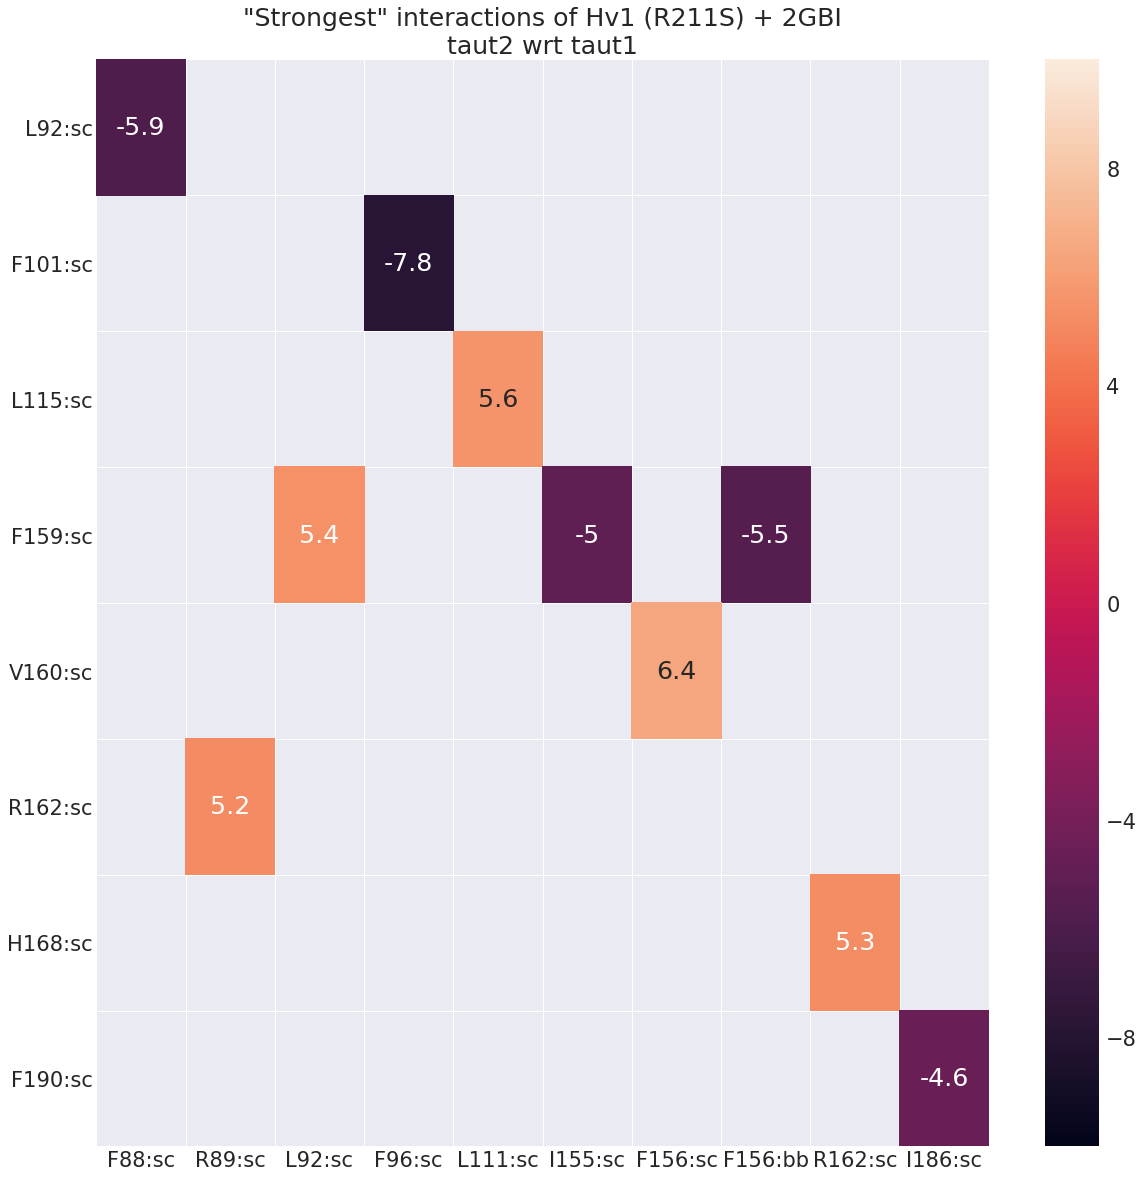

interaction range is from -10 to 10; verify if this is appropriate


In [54]:
diff_nodes_21, diff_edges_21, mutstart_21, offset_21 = diffEdges(nodes_2,nodes_1,edges_2,edges_1)
watless_diff_edges_21 = protLigInts(diff_nodes_21, diff_edges_21,rawNum=25) # make sure you use REFERENCE nodes
plotHeatInts(diff_nodes_21, watless_diff_edges_21, minHeat=-10, maxHeat=10, 
             seltitle="Hv1 ({}) + 2GBI\ntaut2 wrt taut1".format(mutcode))

nodes in 1st, not in 2nd:  [11230 11231 11232 11233]
nodes in 2nd, not in 1st:  [11230 11231 11232 11233]
Shifting node indices by 0 for 0 rows


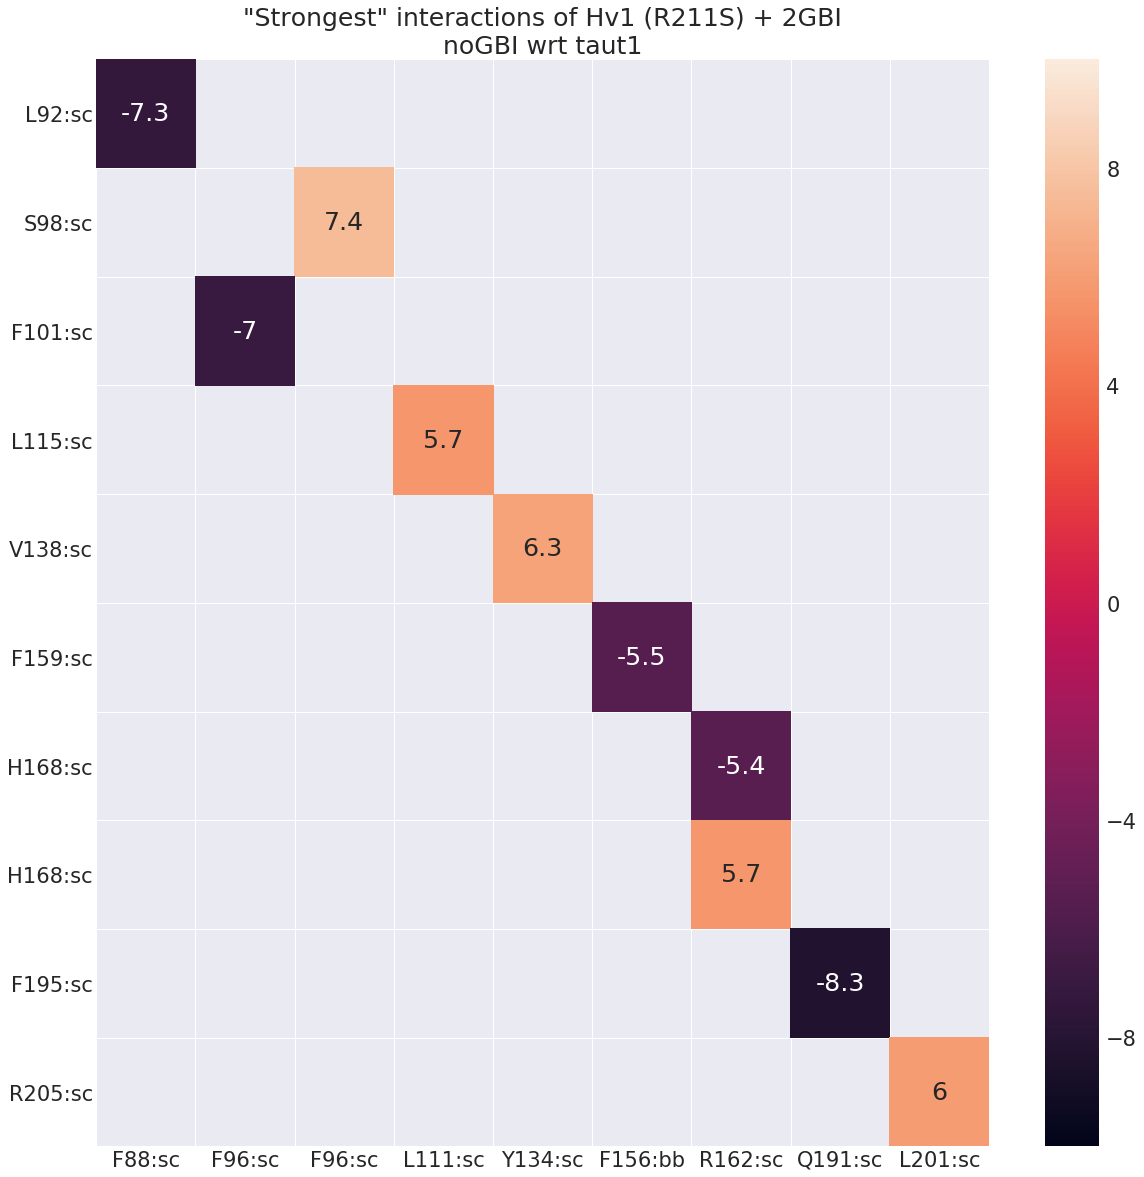

interaction range is from -10 to 10; verify if this is appropriate


In [55]:
diff_nodes_01, diff_edges_01, mutstart_01, offset_01 = diffEdges(nodes_0,nodes_1,edges_0,edges_1)
watless_diff_edges_01 = protLigInts(diff_nodes_01, diff_edges_01,rawNum=25) # make sure you use REFERENCE nodes
plotHeatInts(diff_nodes_01, watless_diff_edges_01, minHeat=-10, maxHeat=10, 
             seltitle="Hv1 ({}) + 2GBI\nnoGBI wrt taut1".format(mutcode))

### 2. Before mutation

[placeholder]

## B. Focus on ligand-specific interactions

### 1. After mutation

[placeholder]

### 2. Before mutation

[placeholder]

# IV. Analyze differences wrt thermodynamic cycle

![thermodynamic_cycle](https://cdn.pbrd.co/images/HaKJ6fc8.png)

For oval as wild-type protein and rectangle as the mutant, the relative binding free energies are calculated as:  
$$\Delta \Delta G = \Delta G_4 - \Delta G_3$$  
(The $\Delta G_1$ and $\Delta G_2$ are the corresponding experimental measurements.)  


In this section of the notebook, compute interaction differences in a roughly analogous manner.  
For example, for the RBFE for the D112E mutation with tautomer 1 of 2GBI:
1. ($\Delta G_4$) Take `edges_e112_taut1` minus `edges_d112_taut1`.  
    This represents the changes in interaction with the ligand present, from before and after mutation.
2. ($\Delta G_3$) Take `edges_e112_noGBI` minus `edges_d112_noGBI`.  
    This represents the changes in interaction _without_ the ligand present, from before and after mutation.
3. Take edges of step 1 minus edges of step 2 to get final set of edges.

**Rationale:**  
* If the mutation causes similar changes in the system with and without the ligand present, that may not be as significant a contributor to the RBFE. However, if there is a change that happens in only one or the other leg of the cycle, that could help pinpoint interactions to qualitatively explain the binding energy.  
* Obviously the 2GBI ligand will not be in the final set of edges because it's not in the `noGBI` case. However, there may be some rearrangements in the residues involved in binding or close to the mutation.
* Output means something along the lines of: interaction strength of 2GBI system, after subtracting interaction strength of noGBI system.

In [56]:
diff_nodes_10, diff_edges_10, mutstart_10, offset_10 = diffdiffEdges(dry_diff_nodes_1,dry_diff_nodes_0,dry_diff_edges_1,dry_diff_edges_0)

nodes in 1st, not in 2nd:  [11227 11228 11229 11230]
nodes in 2nd, not in 1st:  [11227 11228 11229 11230]
Shifting node indices by 0 for 524 rows


/mnt/c/Users/limtv/Documents/vtl_programs/miniconda3/envs/oepython3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/c/Users/limtv/Documents/vtl_programs/miniconda3/envs/oepython3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


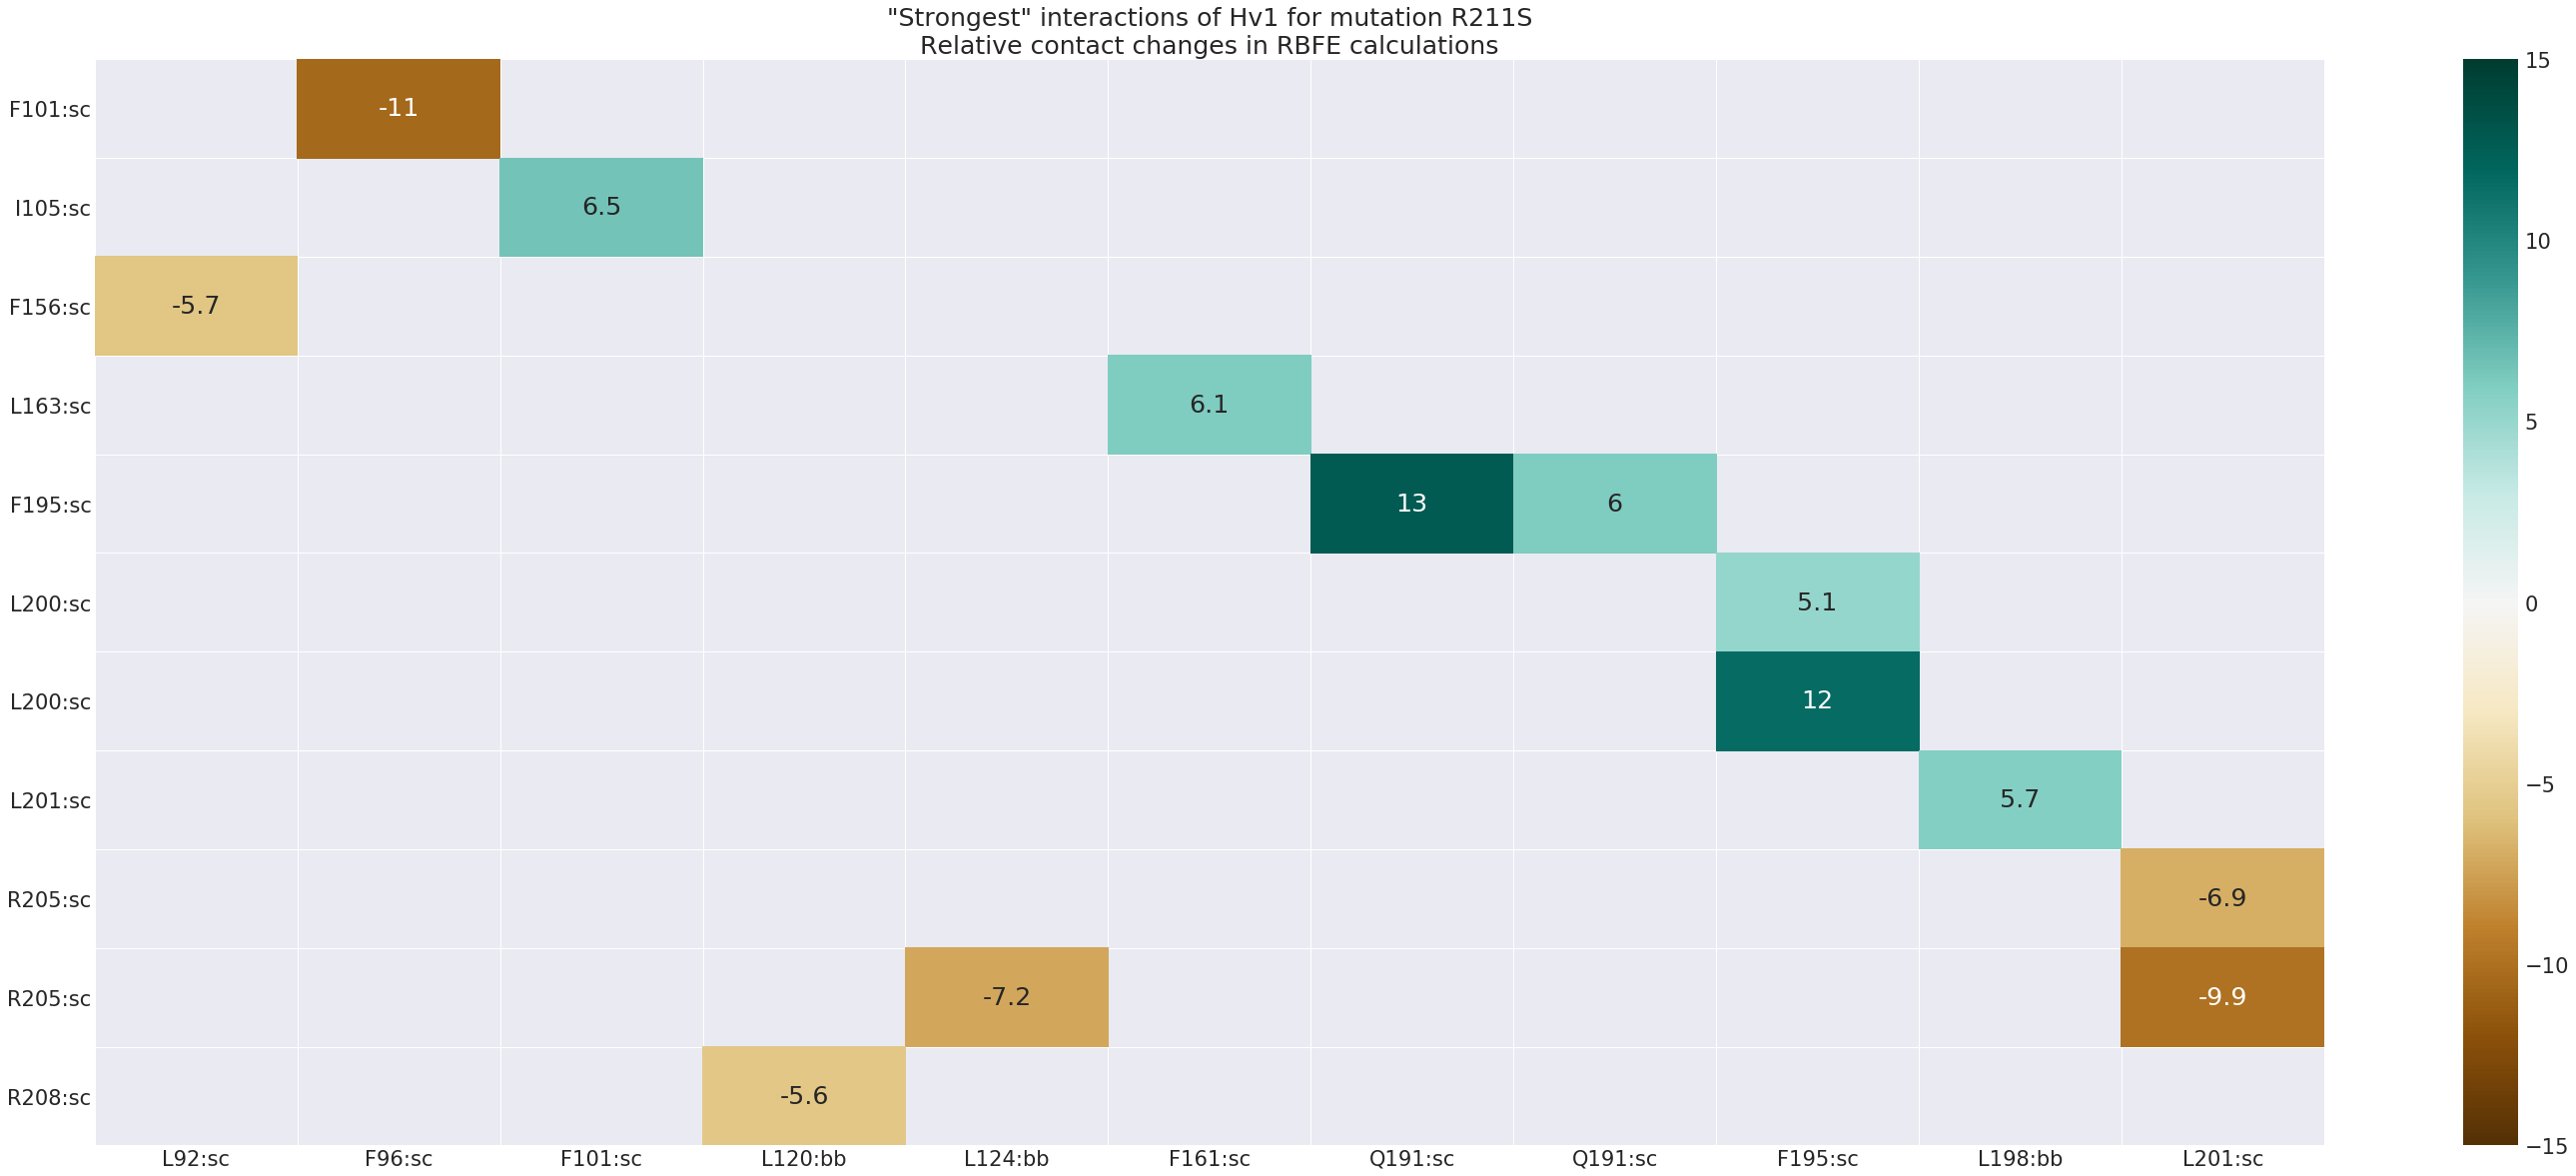

interaction range is from -15 to 15; verify if this is appropriate


In [58]:
pivot_diff_edges_10 = protLigInts(diff_nodes_10, diff_edges_10,dry=2,rawNum=20) # make sure you use REFERENCE nodes
plotHeatInts(diff_nodes_10, pivot_diff_edges_10, minHeat=-15, maxHeat=15, size=(50,20), colors="BrBG",
             seltitle="Hv1 for mutation {}\nRelative contact changes in RBFE calculations".format(mutcode))

** Verify by looking at edge components **

In [59]:
getContactPair(201, 205, dry_diff_nodes_0, dry_diff_edges_0)

      resname resid location type code nAtoms
index                                        
350       LEU   201       sc  NOP   AB      2
351       LEU   201       sc  NOP   GD      3
352       LEU   201       bb  DIP   BB      3 

       resname resid location type code nAtoms
index                                        
362       ARG   205       sc  NOP   AB      2
363       ARG   205       sc  NOP   GD      2
364       ARG   205       sc  POS   EZ      4
365       ARG   205       bb  DIP   BB      3


,node_i,node_j,weight_x,attribute,count_x,average_x,weight_y,count_y,average_y,avg_subt
5992,350,362,3,HPHOB,3,1,2,2,1,0.000000
5993,350,363,409,HPHOB,178,2.29775,848,249,3.40562,-1.107870
5994,350,364,116,STER,116,1,1081,250,4.324,-3.324000
5995,350,365,4,STER,4,1,2,2,1,0.000000
6001,351,363,1216,HPHOB,251,4.84462,43,28,1.53571,3.308907
6002,351,364,2641,STER,251,10.5219,1430,248,5.76613,4.755783


In [60]:
getContactPair(201, 205, dry_diff_nodes_1, dry_diff_edges_1)

      resname resid location type code nAtoms
index                                        
350       LEU   201       sc  NOP   AB      2
351       LEU   201       sc  NOP   GD      3
352       LEU   201       bb  DIP   BB      3 

       resname resid location type code nAtoms
index                                        
362       ARG   205       sc  NOP   AB      2
363       ARG   205       sc  NOP   GD      2
364       ARG   205       sc  POS   EZ      4
365       ARG   205       bb  DIP   BB      3


,node_i,node_j,weight_x,attribute,count_x,average_x,weight_y,count_y,average_y,avg_subt
6797,350,362,3,HPHOB,3,1,2,2,1,0.000000
6798,350,363,530,HPHOB,233,2.27468,367,174,2.1092,0.165483
6799,350,364,705,STER,251,2.80876,65,65,1,1.808765
6804,351,363,43,HPHOB,37,1.16216,1184,250,4.736,-3.573838
6805,351,364,1098,STER,243,4.51852,2419,250,9.676,-5.157481


# V. Analyze interactions directly from computed edges

In other words, absolute interactions not with respect to anything.  
NOTE: Right now, I'm not sure how to interpret these heat maps well or how to make them more useful.

## A. Focus on whole protein-ligand system

### 1. After mutation

#### a. Tautomer 1

In [ ]:
# taut1
#pivot_edges_1 = protLigInts(nodes_1, edges_1)
#plotHeatInts(nodes_1,pivot_edges_1,minHeat=0,maxHeat=20,colors="YlGn")

#### b. Tautomer 2

In [ ]:
# taut2
#watless_edges_2 = protLigInts(nodes_2, edges_2)
#plotHeatInts(nodes_2,watless_edges_2,minHeat=0,maxHeat=20,colors="YlGn")

### 2. Before mutation

[placeholder]

# Troubleshooting

In [ ]:
for i, (index, row) in enumerate(diff_edges_1.iterrows()):
    print('\n ',i,row['node_i'],row['node_j'])
    print(idxToResid(row['node_i'], diff_nodes_1), idxToResid(row['node_j'], diff_nodes_1))

In [ ]:
diff_edges_1.iloc[6955]

In [ ]:
idxToResid(369, diff_nodes_1)

In [ ]:
diff_edges_1.head()

In [ ]:
diff_nodes_1.iloc[365:385]

In [ ]:
findInEdges(380,diff_edges_1)

In [ ]:
edges_1[(edges_1.attribute == 'STER') & (edges_1.weight == 1865)]

In [ ]:
wt_edges_1[(wt_edges_1.attribute == 'HBOND') & (wt_edges_1.weight == 7) & (wt_edges_1.node_i == 413)]